---
>「ものごとの価値観、正邪の判断の基準がすぐれて相対的なものであるということは、いくら強調しておいてもよいだろう。
> 人間のなしうる最良の選択は、視野に映る多くの事象を比較対照して、よりまし、と思われるほうに身をおくことでしかない。」
>
> ヤン・ウェンリー
---

# 同時に2つの目標を達成するネットワーク

複数の関連するタスクを同時に学習する手法をマルチタスク学習と呼ぶ

では、同時に複数の目標を達成したい場合はどうすればよいだろうか

- 物体検出の例
  - 物体認識では、その画像にある物体を認識させるため、認識させたい物体のラベルに合致しているかどうかが問われるが、物体検出では、その画像にある物体のラベルと、その場所、実際にはその大きさなども検出する必要がある
  - このように場所の推定と、物体のラベルの推定を同時に行う必要がある
  - 実際には、複数の物体が存在している可能性があるため、それほど単純化できない
- 文章分類の例
  - 文章分類において、その文章のジャンルラベルの推定と、その文章がある事柄に関してポジティブな内容なのか、ネガティブな内容なのかを識別したいとすると、同様にこれら2つの推定を同時に行う必要がある

そのほか、今後学ぶネットワーク構造のGANなどもGeneratorとDiscriminatorの2つのネットワークを競争的に同時に学習させるように、複数の目的(タスク)を同時に達成するようなモデルを扱うことが多々ある

このようなモデルを構築・学習するにはどうすればよいであろうか

## シンプルに2つのモデルを構築する

これまで学んだ内容だけでも、対応は可能である

上記の例であれば、画像を入力とし、位置を表すベクトルと、物体のラベルを示すベクトルの両方を並べたベクトルを出力とすればよいであろう

ではこれらの複数のその時のロス関数はどのようにすればよいであろうか？

ナイーブには完全に別のネットワークを構築し個別に学習させることである

<img src='http://class.west.sd.keio.ac.jp/dataai/text/multi1.png' width=600>

この手法はこれまで学んだ手法と何ら変わらない

## 2つのモデルにかなりの共通点がある場合のモデル(融合型)

例えば図が物体検出の例を表しているとすると、出力$y_A$つまり物体のラベルについてはクロスエントロピーロス、出力$y_B$つまり物体の位置についてはMSEロスでよいといえ、これらを完全に別々に学習させればよい

この場合、同じ入力xを両方で利用しており、かつ、隠れ層の初期は画像の大局的な特徴をつかむように学習されるとすると、同じような学習を両方で行っているとも考えられ、無駄に思うであろう

では、これを解決するために、次のようなネットワークを構築したとする

<img src='http://class.west.sd.keio.ac.jp/dataai/text/multi2.png' width=600>

それぞれの目的について異なる2つのロス関数が現れることになるが、この場合どのようにして最適化すればよいであろうか

シンプルには、これら2つを足せばよい
- 両方のロス関数ともに正の値をとり、0に近づけることが目的であることから、足した値も0に近づけば両方のロス関数ともに0に近づく

このように、複数の目的を達成する場合、それらのロス関数をすべて足し合わせればよいであろう

ただし、**このような形は実際にはほとんど見ることがない**
- それぞれのロス関数に基づくウェイトの更新がネットワーク全体に波及するため、更新の方向が衝突しあってうまくいかないのではないかという懸念
  - 次の分岐などは、緩衝のための層があると考えることもできる
  - 目的が異なるから複数の目的設定しているので、これを体現するべき
  - 比較上結果が悪くなる傾向にある


## モデル間に共通点が見られるが目的が異なる場合(分岐型)

出力Aで表現したい目的と、出力Bで表現したい目的が異なる場合は、どこかで分岐し、分岐した後にそれぞれの目的にあったネットワークを構築したいと考えるであろう
  - この分岐以降のネットワークが緩衝材となって

<img src='http://class.west.sd.keio.ac.jp/dataai/text/multi3.png' width=600>

このような場合も同様に考えてよい

途中でネットワークが分岐することになるが、このような分岐は、得られたベクトルを1次元ベクトルとし、必要なところのみ切り出してそれぞれ独立したネットワークに入力すればよい
- 分岐そのものは難しくないであろう

さらに言えば、ある条件のときにある分岐のみ算出するといった場合も、それほど気にせずにネットワークと正伝搬を求めればよく、それぞれの目的によって必要な部分のパラメタを更新すればよい

正伝搬さえ計算できれば、その計算記録から逆伝搬を自動的に計算できる、これがDefine-by-Runの凄みである

## 既にあるネットワークの途中から分離してネットワークを追加する(分離追加型)

最後にもう一つ別のパターンを考える

- あるネットワークに対して、もう一つ別の目的を達成するためのネットワークを追加する場合について考えてみよう

<img src='http://class.west.sd.keio.ac.jp/dataai/text/multi4.png' width=600>


このケースでは何が違うのか問うと、ネットワークの記述において、完全に2つの別の記述が存在し、それぞれで最適化するのではなく、全体として最適化を行うという点である
- この場合は、一つの最適化関数に、両方の必要部分のパラメタを更新するように指定するとよい
- それぞれを最適化する場合は特に最適化関数の扱い方に工夫は必要ない(GANのジェネレータとディスクリミネータの場合など)


# 参考プログラム

以下、比較評価するが、乱数を固定して条件を揃える

In [ ]:
import random
import numpy as np
import torch

def torch_fix_seed(seed=24):
    # Python random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True

もうひとつ、GPUについてもここで宣言しておく

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

各例について単体でも実行できるコードを示す
- 最初に基本となる数字認識のみ行う単一目的のMNIST
- 特に複雑なことはしていないがDataLoaderすら用いずに学習させている
  - numpyの配列の要素をランダムに並べ替えた新しい配列を生成する関数を用いてデータを並び替え
  - その先頭からバッチサイズ(bs=200)ごと切り出して学習、最後bs個取得できない場合は最後まで取得
  - これを10エポック行う

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets
import numpy as np
torch_fix_seed()
dataset = datasets.MNIST('./data', train=True, download=True)
x0 = dataset.data.reshape(60000,1,28,28) / 255.0
y0 = dataset.targets

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.cn1 = nn.Conv2d(1, 20, 5)
        self.pool1 = nn.MaxPool2d(2)
        self.cn2 = nn.Conv2d(20, 50, 5)
        self.fc = nn.Linear(50 * 8 * 8, 10)
    def forward(self, x):
        x = F.relu(self.cn1(x))
        x = self.pool1(x)
        x = F.relu(self.cn2(x))
        x = x.view(len(x), -1) # Flatten
        return self.fc(x)

model = CNN().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

n = len(y0)
bs = 200
losses = []
epochs = 5

model.train()
for j in range(epochs):
    idx = np.random.permutation(n)
    for i in range(0, n, bs):
        x = x0[idx[i:(i+bs) if (i+bs) < n else n]].to(device)
        y = y0[idx[i:(i+bs) if (i+bs) < n else n]].to(device)
        output = model(x)
        loss = criterion(output,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    print(j, loss.item())

100%|██████████| 9912422/9912422 [00:00<00:00, 233667241.31it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 100862359.55it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 68622968.58it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 16638016.39it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

0 0.1568564474582672
1 0.051816634833812714
2 0.04602872207760811
3 0.12746264040470123
4 0.02951779216527939


ロスをグラフ化する

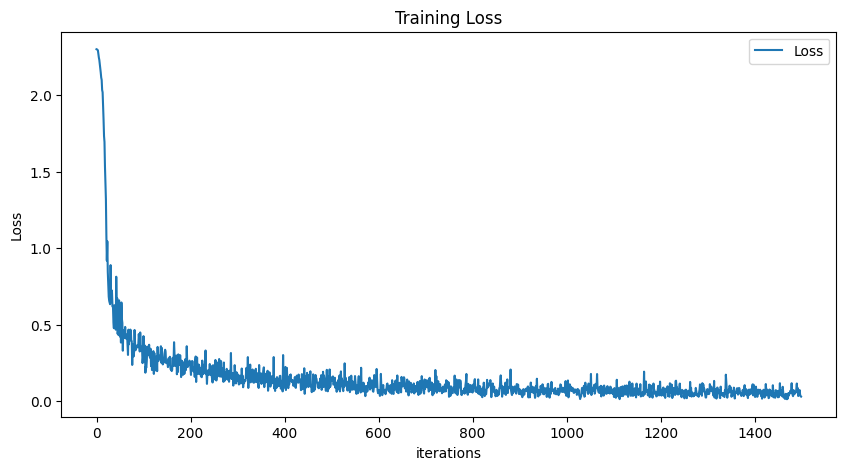

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot(losses,label="Loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

検証用データを用いて検証する

In [ ]:
tdataset = datasets.MNIST('./data', train=False, download=True)
xtest = tdataset.data.reshape(10000,1,28,28) / 255.0
ytest = tdataset.targets
model.eval()
with torch.no_grad():
    y1 = model(xtest.to(device))
    ans = torch.argmax(y1,1).to('cpu')
    print(((ytest == ans).sum().float()/len(ans)).item())

0.9825999736785889


## 融合型(ロス融合型)

2つの独立した簡単なタスクを想定する
- 一つは数字画像の識別でラベルは0から9である
  - 数字の識別はワンホット表現で10出力
- もう一つは数字画像に丸い部分があるかないかを識別し、0,6,8,9の数字のみTrue(1)、なければFalse(0)とする
  - 丸の識別はやはりワンホット表現で2出力

以上あわせて、12出力とする

ネットワークからの出力を単純に切り分けてそれぞれでロスを計算する

ここで、2つロスを計算するのに、criterionつまり、ロス関数は一つでよいのか？という疑問があるとすると、これは心配いらず一つでよい
- 計算するだけで、内部に何も値を保持していない
- クラスではなく純粋に関数である

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets
import numpy as np
torch_fix_seed()
dataset = datasets.MNIST('./data', train=True, download=True)
x0 = dataset.data.reshape(60000,1,28,28) / 255.0
y01 = dataset.targets
y02 = dataset.targets
for i in range(len(y02)):
    if (y02[i] in [6, 8, 9, 0]):
        y02[i] = 1
    else:
        y02[i] = 0

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.cn1 = nn.Conv2d(1, 20, 5)
        self.pool1 = nn.MaxPool2d(2)
        self.cn2 = nn.Conv2d(20, 50, 5)
        self.fc = nn.Linear(3200, 12)
    def forward(self, x):
        x = F.relu(self.cn1(x))
        x = self.pool1(x)
        x = F.relu(self.cn2(x))
        x = x.view(len(x), -1) # Flatten
        x = self.fc(x)
        return x

model = Model().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

n = len(y01)
bs = 200
epochs = 5
losses = []
losses1 = []
losses2 = []

model.train()
for j in range(epochs):
    idx = np.random.permutation(n)
    for i in range(0, n, bs):
        x = x0[idx[i:(i+bs) if (i+bs) < n else n]].to(device)
        y1 = y01[idx[i:(i+bs) if (i+bs) < n else n]].to(device)
        y2 = y02[idx[i:(i+bs) if (i+bs) < n else n]].to(device)
        output = model(x)
        out1 = output[:,0:10]
        out2 = output[:,10:12]
        loss1 = criterion(out1, y1)
        loss2 = criterion(out2, y2)
        loss = loss1 + loss2
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        losses1.append(loss1.item())
        losses2.append(loss2.item())
    print(j, loss.item())

0 0.17400994896888733
1 0.05967719852924347
2 0.07635010033845901
3 0.03752785176038742
4 0.04316709563136101


ロスをグラフにする
- 文字認識のロス(loss1)、丸認識のロス(loss2)、全体のロス(loss)を記載

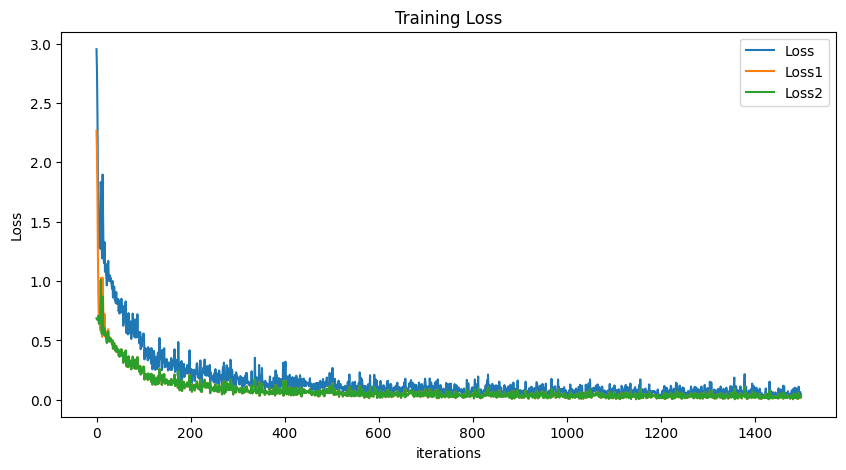

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot(losses,label="Loss")
plt.plot(losses1,label="Loss1")
plt.plot(losses2,label="Loss2")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

検証データを用いて、数字認識と丸認識それぞれの精度を求める

In [ ]:
tdataset = datasets.MNIST('./data', train=False, download=True)
xt = tdataset.data.reshape(10000,1,28,28) / 255.0
yans1 = tdataset.targets
yans2 = tdataset.targets
for i in range(len(yans2)):
    if (yans2[i] in [6, 8, 9]):
        yans2[i] = 1
    else:
        yans2[i] = 0

model.eval()
with torch.no_grad():
    cnnx = model(xt.to(device))
    out1 = cnnx[:,0:10]
    out2 = cnnx[:,10:12]
    ans1 = torch.argmax(out1.to('cpu'), 1)
    ans2 = torch.argmax(out2.to('cpu'), 1)
    print(((yans1 == ans1).sum().float()/len(ans1)).item())
    print(((yans2 == ans2).sum().float()/len(ans2)).item())

0.892799973487854
0.892799973487854


## 融合型(多重更新型)

先ほどと似ているが、`loss = loss1+loss2`とせず、`loss1`と`loss2`それぞれで逆伝搬を求める

この場合、ネットワークは2回逆伝搬で更新されることになるため、通常では`RuntimeError: Trying to backward through the graph a second time, but the buffers have already been freed. `といったエラーが出力される

これを回避するため、backwordメソッドを呼び出す際に`retain_graph=True`としてエラーにならないようにしている

パラメータは、各lossを求める際に、それぞれの値で更新されることになる

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets
import numpy as np
torch_fix_seed()
dataset = datasets.MNIST('./data', train=True, download=True)
x0 = dataset.data.reshape(60000,1,28,28) / 255.0
y01 = dataset.targets
y02 = dataset.targets
for i in range(len(y02)):
    if (y02[i] in [6, 8, 9]):
        y02[i] = 1
    else:
        y02[i] = 0

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.cn1 = nn.Conv2d(1, 20, 5)
        self.pool1 = nn.MaxPool2d(2)
        self.cn2 = nn.Conv2d(20, 50, 5)
        self.fc = nn.Linear(3200, 12)
    def forward(self, x):
        x = F.relu(self.cn1(x))
        x = self.pool1(x)
        x = F.relu(self.cn2(x))
        x = x.view(len(x), -1) # Flatten
        x = self.fc(x)
        return x

model = Model().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

n = len(y01)
bs = 200
epochs = 5
losses1 = []
losses2 = []

model.train()
for j in range(epochs):
    idx = np.random.permutation(n)
    for i in range(0, n, bs):
        x = x0[idx[i:(i+bs) if (i+bs) < n else n]].to(device)
        y1 = y01[idx[i:(i+bs) if (i+bs) < n else n]].to(device)
        y2 = y02[idx[i:(i+bs) if (i+bs) < n else n]].to(device)
        output = model(x)
        out1 = output[:,0:10]
        out2 = output[:,10:12]
        loss1 = criterion(out1, y1)
        loss2 = criterion(out2, y2)
        optimizer.zero_grad()
        loss1.backward(retain_graph=True)
        loss2.backward()
        optimizer.step()
        losses.append(loss.item())
        losses1.append(loss1.item())
        losses2.append(loss2.item())
    print(j, loss1.item(), loss2.item())

0 0.07946358621120453 0.07899975031614304
1 0.0320376493036747 0.03137113153934479
2 0.049605902284383774 0.05069626495242119
3 0.05826083570718765 0.0592060424387455
4 0.028882980346679688 0.028437232598662376


この場合、先ほどの例と比較すると、回数で2倍多く更新を行っているので、条件が合えばより早く収束することになる

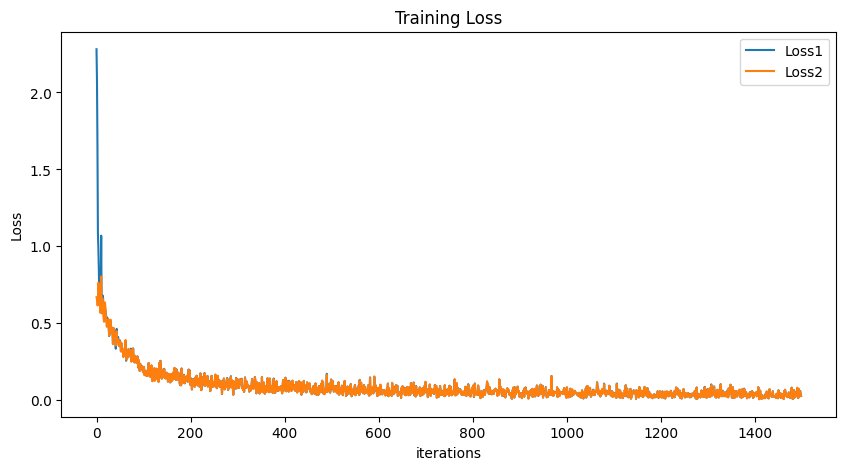

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot(losses1,label="Loss1")
plt.plot(losses2,label="Loss2")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

検証データを用いて、数字認識と丸認識それぞれの精度を求める

2つを同時に行うため、2つは揃って精度を高めあうことになる
- 従って、先の例の中間的な精度になると予想できる

In [ ]:
tdataset = datasets.MNIST('./data', train=False, download=True)
xt = tdataset.data.reshape(10000,1,28,28) / 255.0
yans1 = tdataset.targets
yans2 = tdataset.targets
for i in range(len(yans2)):
    if (yans2[i] in [6, 8, 9]):
        yans2[i] = 1
    else:
        yans2[i] = 0

model.eval()
with torch.no_grad():
    cnnx = model(xt.to(device))
    out1 = cnnx[:,0:10]
    out2 = cnnx[:,10:12]
    ans1 = torch.argmax(out1.to('cpu'), 1)
    ans2 = torch.argmax(out2.to('cpu'), 1)
    print(((yans1 == ans1).sum().float()/len(ans1)).item())
    print(((yans2 == ans2).sum().float()/len(ans2)).item())

0.9871000051498413
0.9869999885559082


## 分岐型

分岐させるために、分岐後それぞれのタスクを担当するfc1、fc2を定義する
- モデルではfc1、fc2を定義しているが、モデル内では利用していない
- `output = model(x)`を求めた後、`out1 = model.fc1(output)`および、`out2 = model.fc2(output)`としてそれぞれ求める

この場合でも、fc1を利用する数字識別タスクのforwardと、fc2を利用する丸識別タスクのforwardそれぞれについて損失を算出し、最適化関数を呼び出せばよい
- ただし、backwordは一度でまとめて呼び出すため、`loss`を`loss1+loss2`として加算してたのち、backwordを求める

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets
import numpy as np
torch_fix_seed()
dataset = datasets.MNIST('./data', train=True, download=True)
x0 = dataset.data.reshape(60000,1,28,28) / 255.0
y01 = dataset.targets
y02 = dataset.targets
for i in range(len(y02)):
    if (y02[i] in [6, 8, 9]):
        y02[i] = 1
    else:
        y02[i] = 0

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.cn1 = nn.Conv2d(1, 20, 5)
        self.pool1 = nn.MaxPool2d(2)
        self.cn2 = nn.Conv2d(20, 50, 5)
        self.fc1 = nn.Linear(3200, 10)
        self.fc2 = nn.Linear(3200, 2)
    def forward(self, x):
        x = F.relu(self.cn1(x))
        x = self.pool1(x)
        x = F.relu(self.cn2(x))
        x = x.view(len(x), -1)
        return x

model = Model().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

n = len(y01)
bs = 200
epochs = 5
losses = []
losses1 = []
losses2 = []

model.train()
for j in range(epochs):
    idx = np.random.permutation(n)
    for i in range(0, n, bs):
        x = x0[idx[i:(i+bs) if (i+bs) < n else n]].to(device)
        y1 = y01[idx[i:(i+bs) if (i+bs) < n else n]].to(device)
        y2 = y02[idx[i:(i+bs) if (i+bs) < n else n]].to(device)
        output = model(x)
        out1 = model.fc1(output)
        out2 = model.fc2(output)
        loss1 = criterion(out1,y1)
        loss2 = criterion(out2,y2)
        loss = loss1 + loss2
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        losses1.append(loss1.item())
        losses2.append(loss2.item())
    print(j, loss.item())

0 0.19580642879009247
1 0.07742133736610413
2 0.1095210462808609
3 0.11993841826915741
4 0.06332653760910034


ロス曲線を描画する

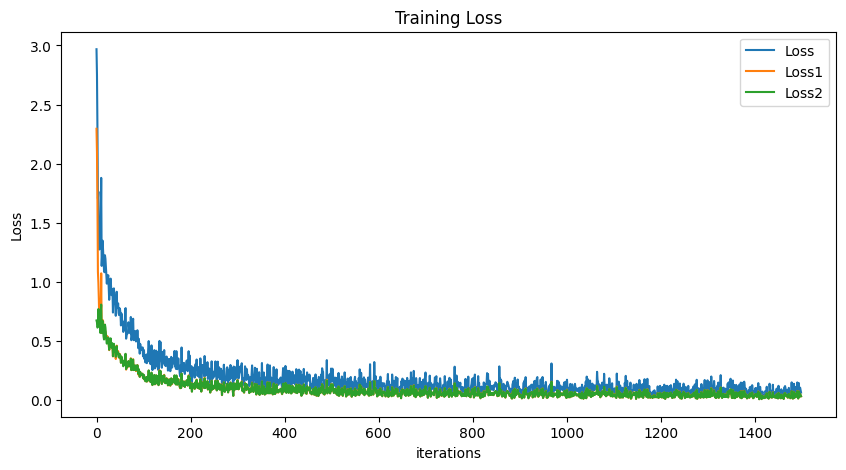

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot(losses,label="Loss")
plt.plot(losses1,label="Loss1")
plt.plot(losses2,label="Loss2")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

検証データで精度を求める

In [ ]:
tdataset = datasets.MNIST('./data', train=False, download=True)
xt = tdataset.data.reshape(10000,1,28,28) / 255.0
yans1 = tdataset.targets
yans2 = tdataset.targets
for i in range(len(yans2)):
    if (yans2[i] in [6, 8, 9]):
        yans2[i] = 1
    else:
        yans2[i] = 0

model.eval()
with torch.no_grad():
    cnnx = model(xt.to(device))
    out1 = model.fc1(cnnx.to(device))
    out2 = model.fc2(cnnx.to(device))
    ans1 = torch.argmax(out1.to('cpu'), 1)
    ans2 = torch.argmax(out2.to('cpu'), 1)
    print(((yans1 == ans1).sum().float()/len(ans1)).item())
    print(((yans2 == ans2).sum().float()/len(ans2)).item())

0.9882000088691711
0.988099992275238


なお、融合型と分岐型のどちらが精度がよくなるかは扱うタスクに依存し、慎重に検討、適切に選択する必要がある
- 今回の場合、結果は各自で異なると思われるが、ほぼ同じ、どちらがよくなるかは乱数に依存するであろう

特に、個別に設けたネットワークの独自性が十分に発揮できるかどうかの議論が必要である

- 分離型にすることで、片方だけリッチなネットワークを提供できるため、問題の複雑度合いに対応することができるであろう
- 相互でノードの数が等しい場合は、融合型の方が結果的に最終層のノード間接続数が多くなり、能力が高くなる可能性がある
  - つまり、分離するならば、複雑度合いを変えるべき問題を扱い、そのようなネットワークを構築するべきである



## 分岐型(多重更新型)

先ほどの多重更新型と同様、`loss = loss1+loss2`とせず、`loss1`と`loss2`それぞれで逆伝搬を求める

同様に、backwordメソッドを呼び出す際に`retain_graph=True`としてエラーにならないようにしている

パラメータは、各lossを求める際に、それぞれの値で更新されることになる

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets
import numpy as np
torch_fix_seed()
dataset = datasets.MNIST('./data', train=True, download=True)
x0 = dataset.data.reshape(60000,1,28,28) / 255.0
y01 = dataset.targets
y02 = dataset.targets
for i in range(len(y02)):
    if (y02[i] in [6, 8, 9]):
        y02[i] = 1
    else:
        y02[i] = 0

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.cn1 = nn.Conv2d(1, 20, 5)
        self.pool1 = nn.MaxPool2d(2)
        self.cn2 = nn.Conv2d(20, 50, 5)
        self.fc1 = nn.Linear(3200, 10)
        self.fc2 = nn.Linear(3200, 2)
    def forward(self, x):
        x = F.relu(self.cn1(x))
        x = self.pool1(x)
        x = F.relu(self.cn2(x))
        x = x.view(len(x), -1)
        return x

model = Model().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

n = len(y01)
bs = 200
epochs = 5
losses1 = []
losses2 = []

model.train()
for j in range(epochs):
    idx = np.random.permutation(n)
    for i in range(0, n, bs):
        x = x0[idx[i:(i+bs) if (i+bs) < n else n]].to(device)
        y1 = y01[idx[i:(i+bs) if (i+bs) < n else n]].to(device)
        y2 = y02[idx[i:(i+bs) if (i+bs) < n else n]].to(device)
        output = model(x)
        out1 = model.fc1(output)
        out2 = model.fc2(output)
        loss1 = criterion(out1,y1)
        loss2 = criterion(out2,y2)
        optimizer.zero_grad()
        loss1.backward(retain_graph=True)
        loss2.backward()
        optimizer.step()
        losses1.append(loss1.item())
        losses2.append(loss2.item())
    print(j, loss1.item(), loss2.item())

0 0.09523224830627441 0.0917118489742279
1 0.03837329521775246 0.03771641105413437
2 0.05395577475428581 0.05355734005570412
3 0.06061471626162529 0.06036201864480972
4 0.031300775706768036 0.03186480700969696


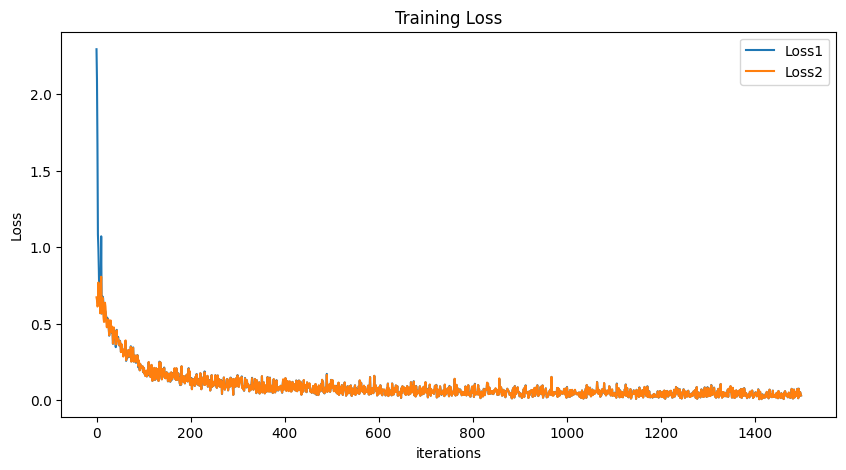

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot(losses1,label="Loss1")
plt.plot(losses2,label="Loss2")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

検証データを用いて、数字認識と丸認識それぞれの精度を求める
- 先ほどよりもネットワーク前段の学習回数が多くなるため、過学習にならなければ、若干改善することが予測される

In [ ]:
tdataset = datasets.MNIST('./data', train=False, download=True)
xt = tdataset.data.reshape(10000,1,28,28) / 255.0
yans1 = tdataset.targets
yans2 = tdataset.targets
for i in range(len(yans2)):
    if (yans2[i] in [6, 8, 9]):
        yans2[i] = 1
    else:
        yans2[i] = 0

model.eval()
with torch.no_grad():
    cnnx = model(xt.to(device))
    out1 = model.fc1(cnnx.to(device))
    out2 = model.fc2(cnnx.to(device))
    ans1 = torch.argmax(out1.to('cpu'), 1)
    ans2 = torch.argmax(out2.to('cpu'), 1)
    print(((yans1 == ans1).sum().float()/len(ans1)).item())
    print(((yans2 == ans2).sum().float()/len(ans2)).item())

0.9878000020980835
0.988099992275238


## 分離追加型

すでに存在するネットワーク(CNN1)があり、それをそのまま無改変で利用したい(コードを改変したくない)場合は、分岐のためのネットワーク改変が直接的にできない
- そこで、新たなネットワーク(CNN2)を構築し、分岐させていたところから同様にCNN2へとつなげる
- 結果的に分岐型と同じであるが、実現のさせ方が異なる

分離して追加する方法
- 独自のネットワーク(ここではCNN2)を定義する
- CNN1のネットワークの途中ノードからリンク(重みを掛けて次のノードに伝える線)を取り出すため、どうしてもforwardに手を入れる必要がある
  - CNN1のクラス定義に手を入れずに、その途中からデータを取り出すため、別途forward(ここではfwd関数)を定義する
  - このforwardにおけるノードの呼び出し方について、既に宣言済みのネットワークのノードを参照するため独特となる
  - クラスの中で定義する必要はない
- 別途forwardを定義したため、学習や検証ではこのforwardを呼び出す
- 分岐した後、追加側のネットワークと、元のネットワークの残りの部分の計算を行う
  - ここでは元のネットワークの残りの部分が1層のみであるため直接呼び出しているが、この部分が大きい場合は、新たなfwd関数を準備して処理するとよい
  - つまり、今回は、CNN1をfwdとfcに分割しているが、CNN1をfwd1とfwd2に分割して処理するようにするとよい

この場合、最も困難なのは最適化をどのように行うかである

```
optimizer = optim.SGD([
    {'params': model1.parameters()},
    {'params': model2.parameters()}
], lr=0.01, momentum=0.9)
```

PyTorchの最適化関数について、その第1引数は、torch.Tensorのiterableもしくは、dict型で指定する必要がある
- 通常は、model.parameters()とするが、このmode.parameters()を実際に見るとわかる通り、各層のネットワークのパラメタが全て含まれたdict型の変数であることがわかる
  - これについては、後で確認してみよう
- モデルが複数ある場合、dict型で束ねれば、全体について記述するとよい
  - ここでは、CNN1とCNN2があるため、両方指定する必要がある
- 別途記述したfwdは、とにかく計算してあげれば、AutoGradにより全計算手順がtorch.tensorの型の中で保存されるため、特に何もケアする必要はない
  - つまり、パラメタだけ渡せば、どのような途中計算をクラス外で行おうとも、パラメタ更新を行うことができる
  - これも、Define-by-Runの特徴

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets
import numpy as np
torch_fix_seed()
dataset = datasets.MNIST('./data', train=True, download=True)
x0 = dataset.data.reshape(60000,1,28,28) / 255.0
y01 = dataset.targets
y02 = dataset.targets
for i in range(len(y02)):
    if (y02[i] in [6, 8, 9]):
        y02[i] = 1
    else:
        y02[i] = 0

class CNN1(nn.Module):
    def __init__(self):
        super(CNN1, self).__init__()
        self.cn1 = nn.Conv2d(1, 20, 5)
        self.pool1 = nn.MaxPool2d(2)
        self.cn2 = nn.Conv2d(20, 50, 5)
        self.fc = nn.Linear(3200, 10)
    def forward(self, x):
        x = F.relu(self.cn1(x))
        x = self.pool1(x)
        x = F.relu(self.cn2(x))
        x = x.view(len(x), -1)
        return self.fc(x)

class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.fc = nn.Linear(3200, 2)
    def forward(self, x):
        return self.fc(x)

model1 = CNN1().to(device)
model2 = CNN2().to(device)
optimizer = optim.SGD([
    {'params': model1.parameters()},
    {'params': model2.parameters()}
], lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

def fwd(model, x):
    x = F.relu(model.cn1(x))
    x = model.pool1(x)
    x = F.relu(model.cn2(x))
    x = x.view(len(x), -1)
    return x

n = len(y01)
bs = 200
epochs = 5
losses = []
losses1 = []
losses2 = []

model1.train()
model2.train()

for j in range(epochs):
    idx = np.random.permutation(n)
    for i in range(0, n, bs):
        x = x0[idx[i:(i+bs) if (i+bs) < n else n]].to(device)
        y1 = y01[idx[i:(i+bs) if (i+bs) < n else n]].to(device)
        y2 = y02[idx[i:(i+bs) if (i+bs) < n else n]].to(device)
        output = fwd(model1, x)
        out1 = model1.fc(output)
        out2 = model2(output)
        loss1 = criterion(out1,y1)
        loss2 = criterion(out2,y2)
        loss = loss1 + loss2
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        losses1.append(loss1.item())
        losses2.append(loss2.item())
    print(j, loss.item())

0 0.19580642879009247
1 0.07742133736610413
2 0.1095210462808609
3 0.11993841826915741
4 0.06332653760910034


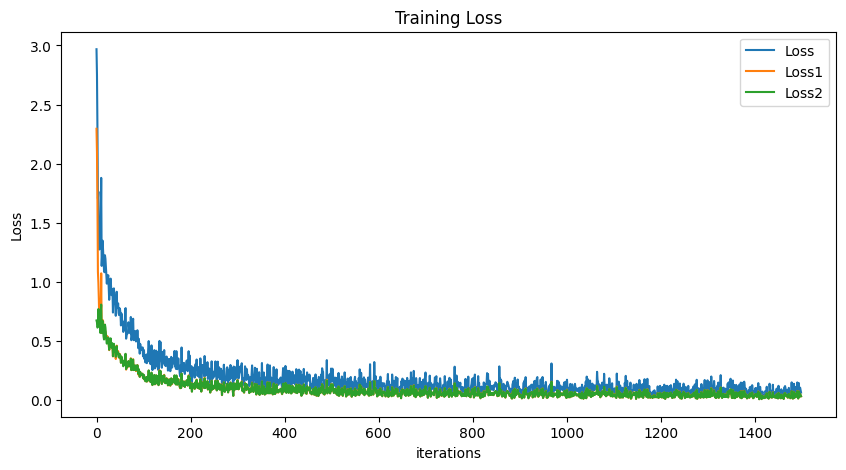

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot(losses,label="Loss")
plt.plot(losses1,label="Loss1")
plt.plot(losses2,label="Loss2")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
model1.eval()
model2.eval()
with torch.no_grad():
    cnnx = fwd(model1, xt.to(device))
    out1 = model1.fc(cnnx)
    out2 = model2(cnnx)
    ans1 = torch.argmax(out1,1).to('cpu')
    ans2 = torch.argmax(out2,1).to('cpu')
    print(((yans1 == ans1).sum().float()/len(ans1)).item())
    print(((yans2 == ans2).sum().float()/len(ans2)).item())

0.9882000088691711
0.988099992275238


本質的に、何も変わらないはずで、結果つまり精度も分離型とほぼ同じになる

## 結果再利用型

まず、普通にMNISTの手書き数字認識を行った後、その結果をもう一つのタスク、丸を含むかどうかを求めるネットワークに入力して学習させる
- これが上手くいくのは、最初の予測結果がそのまま、次の予測結果に使えることがわかっている時のみ
- 今回は、数字認識ができれば、丸の有り無しも当然予測できるはずであるためうまくいく

このとき、丸を含むかどうかを求めるネットワークの学習時に、手前の手書き数字認識を求めるネットワークを更新しないようにparmを設定している

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets
import numpy as np
torch_fix_seed()
dataset = datasets.MNIST('./data', train=True, download=True)
x0 = dataset.data.reshape(60000,1,28,28) / 255.0
y01 = dataset.targets
y02 = dataset.targets
for i in range(len(y02)):
    if (y02[i] in [6, 8, 9]):
        y02[i] = 1
    else:
        y02[i] = 0

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.cn1 = nn.Conv2d(1, 20, 5)
        self.pool1 = nn.MaxPool2d(2)
        self.cn2 = nn.Conv2d(20, 50, 5)
        self.fc = nn.Linear(50 * 8 * 8, 10)
    def forward(self, x):
        x = F.relu(self.cn1(x))
        x = self.pool1(x)
        x = F.relu(self.cn2(x))
        x = x.view(len(x), -1) # Flatten
        return self.fc(x)

class FC(nn.Module):
    def __init__(self):
        super(FC, self).__init__()
        self.fc1 = nn.Linear(10, 10)
        self.fc2 = nn.Linear(10, 2)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

model1 = CNN().to(device)
model2 = FC().to(device)
optimizer1 = optim.SGD(model1.parameters(), lr=0.01, momentum=0.9)
optimizer2 = optim.SGD(model2.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

n = len(y0)
bs = 200
epochs = 5
losses1 = []
losses2 = []

model.train()
for j in range(epochs):
    idx = np.random.permutation(n)
    for i in range(0, n, bs):
        x = x0[idx[i:(i+bs) if (i+bs) < n else n]].to(device)
        y1 = y01[idx[i:(i+bs) if (i+bs) < n else n]].to(device)
        y2 = y02[idx[i:(i+bs) if (i+bs) < n else n]].to(device)
        for param in model1.parameters():
            param.requires_grad = True
        output = model1(x)
        loss1 = criterion(output,y1)
        optimizer1.zero_grad()
        loss1.backward()
        optimizer1.step()
        for param in model1.parameters():
            param.requires_grad = False
        input2 = output.detach().clone()
        output = model2(input2)
        loss2 = criterion(output,y2)
        optimizer2.zero_grad()
        loss2.backward()
        optimizer2.step()
        losses1.append(loss1.item())
        losses2.append(loss2.item())
    print(j, loss1.item(), loss2.item())

0 0.12227962166070938 0.133080393075943
1 0.03656405583024025 0.03231984004378319
2 0.07465784251689911 0.07857148349285126
3 0.06989564746618271 0.07584960013628006
4 0.0421857126057148 0.042187996208667755


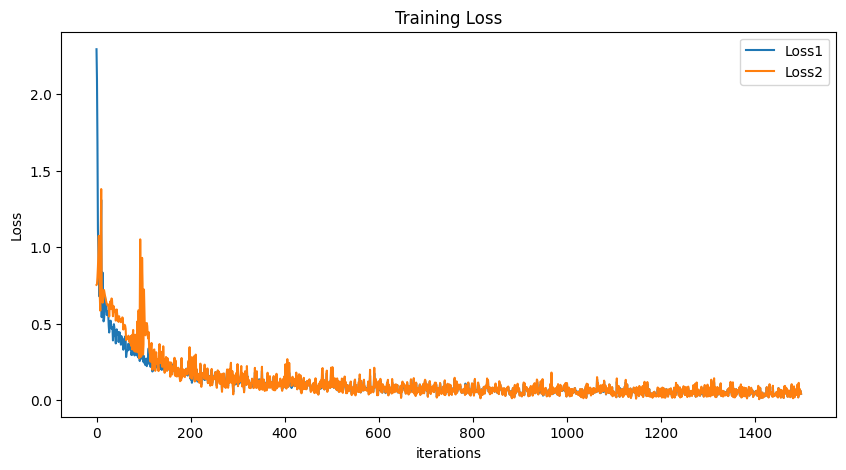

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot(losses1,label="Loss1")
plt.plot(losses2,label="Loss2")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
tdataset = datasets.MNIST('./data', train=False, download=True)
xt = tdataset.data.reshape(10000,1,28,28) / 255.0
yans1 = tdataset.targets
yans2 = tdataset.targets
for i in range(len(yans2)):
    if (yans2[i] in [6, 8, 9]):
        yans2[i] = 1
    else:
        yans2[i] = 0

model1.eval()
model2.eval()
with torch.no_grad():
    out1 = model1(xt.to(device))
    out2 = model2(out1)
    ans1 = torch.argmax(out1,1).to('cpu')
    ans2 = torch.argmax(out2,1).to('cpu')
    print(((yans1 == ans1).sum().float()/len(ans1)).item())
    print(((yans2 == ans2).sum().float()/len(ans2)).item())

0.9850000143051147
0.9847999811172485


## 結果再利用型(多重更新型)

先の例を多重更新に変更する

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets
import numpy as np
torch_fix_seed()
dataset = datasets.MNIST('./data', train=True, download=True)
x0 = dataset.data.reshape(60000,1,28,28) / 255.0
y01 = dataset.targets
y02 = dataset.targets
for i in range(len(y02)):
    if (y02[i] in [6, 8, 9]):
        y02[i] = 1
    else:
        y02[i] = 0

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.cn1 = nn.Conv2d(1, 20, 5)
        self.pool1 = nn.MaxPool2d(2)
        self.cn2 = nn.Conv2d(20, 50, 5)
        self.fc = nn.Linear(50 * 8 * 8, 10)
    def forward(self, x):
        x = F.relu(self.cn1(x))
        x = self.pool1(x)
        x = F.relu(self.cn2(x))
        x = x.view(len(x), -1) # Flatten
        return self.fc(x)

class FC(nn.Module):
    def __init__(self):
        super(FC, self).__init__()
        self.fc1 = nn.Linear(10, 10)
        self.fc2 = nn.Linear(10, 2)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

model1 = CNN().to(device)
model2 = FC().to(device)
optimizer1 = optim.SGD(model1.parameters(), lr=0.01, momentum=0.9)
optimizer2 = optim.SGD(model2.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

n = len(y0)
bs = 200
epochs = 5
losses1 = []
losses2 = []

model.train()
for j in range(epochs):
    idx = np.random.permutation(n)
    for i in range(0, n, bs):
        x = x0[idx[i:(i+bs) if (i+bs) < n else n]].to(device)
        y1 = y01[idx[i:(i+bs) if (i+bs) < n else n]].to(device)
        y2 = y02[idx[i:(i+bs) if (i+bs) < n else n]].to(device)
        output = model1(x)
        loss1 = criterion(output,y1)
        optimizer1.zero_grad()
        loss1.backward(retain_graph=True)
        optimizer1.step()
        input2 = output.detach().clone()
        output = model2(input2)
        loss2 = criterion(output,y2)
        optimizer2.zero_grad()
        loss2.backward()
        optimizer2.step()
        losses1.append(loss1.item())
        losses2.append(loss2.item())
    print(j, loss1.item(), loss2.item())

0 0.12227962166070938 0.133080393075943
1 0.03656405583024025 0.03231984004378319
2 0.07465784251689911 0.07857148349285126
3 0.06989564746618271 0.07584960013628006
4 0.0421857126057148 0.042187996208667755


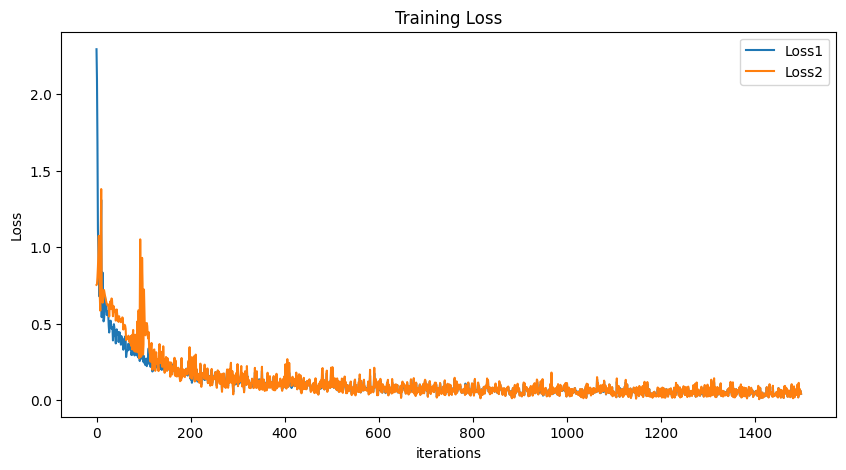

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot(losses1,label="Loss1")
plt.plot(losses2,label="Loss2")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
tdataset = datasets.MNIST('./data', train=False, download=True)
xt = tdataset.data.reshape(10000,1,28,28) / 255.0
yans1 = tdataset.targets
yans2 = tdataset.targets
for i in range(len(yans2)):
    if (yans2[i] in [6, 8, 9]):
        yans2[i] = 1
    else:
        yans2[i] = 0

model1.eval()
model2.eval()
with torch.no_grad():
    out1 = model1(xt.to(device))
    out2 = model2(out1)
    ans1 = torch.argmax(out1,1).to('cpu')
    ans2 = torch.argmax(out2,1).to('cpu')
    print(((yans1 == ans1).sum().float()/len(ans1)).item())
    print(((yans2 == ans2).sum().float()/len(ans2)).item())

0.9850000143051147
0.9847999811172485


## (コラム) detach()とcloneについて

ここで、`detach().clone()`としてmodel2のネットワークを構築しているが、この順番は答えを得る上ではどうでもよい

しかしながら、実際には`clone().detach()`とすると異なる自動微分の計算グラフが構成される

既に述べているが、ここでdetachとcloneについて、より詳しく理解しよう

### detach()

detach()メソッドは、同一デバイス上に新しいtorch.tensorを作成し、元の自動微分の計算グラフから切り離されるが、値は共有している
- 結果的にrequireds_grad=Falseとなる
- コピー先を変更するとコピー元も変更される

In [ ]:
DEVICE = torch.device("cuda")
x = torch.tensor([2.0], device=DEVICE, requires_grad=False)
w = torch.tensor([1.0], device=DEVICE, requires_grad=True)
b = torch.tensor([3.0], device=DEVICE, requires_grad=True)
y = x*w+b
y.backward()
print("x:", x, x.grad, x.requires_grad, "\nw:", w, w.grad, w.requires_grad,
      "\nb:", b, b.grad, b.requires_grad, "\ny:", y, y.grad, y.requires_grad)

x: tensor([2.], device='cuda:0') None False 
w: tensor([1.], device='cuda:0', requires_grad=True) tensor([2.], device='cuda:0') True 
b: tensor([3.], device='cuda:0', requires_grad=True) tensor([1.], device='cuda:0') True 
y: tensor([5.], device='cuda:0', grad_fn=<AddBackward0>) None True


<ipython-input-27-1eed57f15300>:8: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:486.)
  "\nb:", b, b.grad, b.requires_grad, "\ny:", y, y.grad, y.requires_grad)


これに対して、wに対してdetach()を呼び出すと次のようになる
- detachされたので、requireds_gradはFalseになるが、同じメモリ空間を指しており、配列の中身は共有している

In [ ]:
z = w.detach()
print("z:", z, z.grad, z.requires_grad)
print(z is w)

z: tensor([1.], device='cuda:0') None False
False


同じメモリ領域を共有しているため、zの[0]を変更するとwも変更される

In [ ]:
print(w, z)
z[0] = 2
print(w, z)

tensor([1.], device='cuda:0', requires_grad=True) tensor([1.], device='cuda:0')
tensor([2.], device='cuda:0', requires_grad=True) tensor([2.], device='cuda:0')


ちなみに、`w[0] = 2`とすると、`RuntimeError: a view of a leaf Variable that requires grad is being used in an in-place operation.`と表示されエラーとなる

従って、ここでは、無理やりrequires_gradをFalseにしてあげることで、wを変更してもzが変更されることが確認できる

In [ ]:
w.requires_grad_(False)

tensor([2.], device='cuda:0')

In [ ]:
w[0] = 3
print(w, z)

tensor([3.], device='cuda:0') tensor([3.], device='cuda:0')


さらに、zは単独で計算グラフの先頭(端)にあるため、is_leafでもTrueとなる

In [ ]:
z.is_leaf

True

この場合の計算グラフはdetachの前後で次のように変化する

<img src='http://class.west.sd.keio.ac.jp/dataai/text/dc-detach.png' width=800>



### clone

.clone() は同一デバイス上に新しいテンソルを作成し、clone元のテンソルに対して、自動微分の計算グラフが継続して構築される
- cloneでは、異なるメモリ空間を指すためisではFalseとなり、端でもない
- requires_gradはTrueとなる

In [ ]:
x = torch.tensor([2.0], device=DEVICE, requires_grad=False)
w = torch.tensor([1.0], device=DEVICE, requires_grad=True)
b = torch.tensor([3.0], device=DEVICE, requires_grad=True)
v = w.clone()
y = x*v + b
y.backward()
print("x:", x, x.grad, x.requires_grad, "\nw:", w, w.grad, w.requires_grad, "\nv:", v, v.grad, v.requires_grad,
      "\nb:", b, b.grad, b.requires_grad, "\ny:", y, y.grad, y.requires_grad)
print(v is w)
print(v.is_leaf)
print(v.requires_grad)

x: tensor([2.], device='cuda:0') None False 
w: tensor([1.], device='cuda:0', requires_grad=True) tensor([2.], device='cuda:0') True 
v: tensor([1.], device='cuda:0', grad_fn=<CloneBackward0>) None True 
b: tensor([3.], device='cuda:0', requires_grad=True) tensor([1.], device='cuda:0') True 
y: tensor([5.], device='cuda:0', grad_fn=<AddBackward0>) None True
False
False
True


<ipython-input-33-f24e22000a5b>:7: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:486.)
  print("x:", x, x.grad, x.requires_grad, "\nw:", w, w.grad, w.requires_grad, "\nv:", v, v.grad, v.requires_grad,
<ipython-input-33-f24e22000a5b>:8: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, ma

さて、この場合の計算グラフであるが、実際にはwのcloneであるvがxとの掛け算に繋がり、wとvの間に何も計算はない
- 実際、CLoneBackword0と記述され、計算ではない
- そこで、無理やりであるがcloneという演算があるとして表記する
ここで、$y = x \times v + b$をグラフで表記し、vのcloneであるwを1との掛け算で表すと次のようになる

<img src='http://class.west.sd.keio.ac.jp/dataai/text/dc-clone.png' width=500>


### GPUとCPUをまたぐ場合



.cpu()はcpu上のメモリにテンソルを生成するため、gpuにあるyとは違うメモリを参照するため、独立する

しかしながら、自動微分の計算グラフはつながるため、逆伝搬は可能である

In [ ]:
x = torch.tensor([2.0], device=DEVICE, requires_grad=False)
w = torch.tensor([1.0], device=DEVICE, requires_grad=True)
b = torch.tensor([3.0], device=DEVICE, requires_grad=True)
y = x*w + b
z = y.cpu()
v = torch.tensor([7.0], device="cpu", requires_grad=True)
c = torch.tensor([4.0], device="cpu", requires_grad=True)
f = v*z + c
f.backward()

In [ ]:
print(x)
print(w)
print(b)
print(y)
print(z)
print(v)
print(c)
print(f)

tensor([2.], device='cuda:0')
tensor([1.], device='cuda:0', requires_grad=True)
tensor([3.], device='cuda:0', requires_grad=True)
tensor([5.], device='cuda:0', grad_fn=<AddBackward0>)
tensor([5.], grad_fn=<ToCopyBackward0>)
tensor([7.], requires_grad=True)
tensor([4.], requires_grad=True)
tensor([39.], grad_fn=<AddBackward0>)


In [ ]:
print(x.grad)
print(w.grad)
print(b.grad)
print(y.grad)
print(z.grad)
print(v.grad)
print(c.grad)
print(f.grad)

None
tensor([14.], device='cuda:0')
tensor([7.], device='cuda:0')
None
None
tensor([5.])
tensor([1.])
None


<ipython-input-36-78560d9950ec>:4: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:486.)
  print(y.grad)
<ipython-input-36-78560d9950ec>:5: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more inf

In [ ]:
print(z.is_leaf)
print(v.is_leaf)
print(c.is_leaf)
print(f.is_leaf)
print(z.requires_grad)
print(v.requires_grad)
print(c.requires_grad)
print(f.requires_grad)

False
True
True
False
True
True
True
True


この場合の計算グラフは次のようになる

<img src='http://class.west.sd.keio.ac.jp/dataai/text/dc-gpucpu.png' width=600>

ここまでを踏まえると次のことがわかるであろう

detach().clone()

- .detach()して得られるテンソルは計算グラフから切り離されたテンソルであり、これを.clone()するため、メモリの参照場所も異なる独立した値となる
- 値として独立したテンソルであり逆伝播しない

clone().detach()

- .clone()して得られるテンソルは異なるメモリを参照しているが、計算グラフは繋がっている
- これを.detach()するため、計算グラフから切り離される

つまり、ここではこれらは動作上意味となるが、実際には計算グラフは異なる
```
b = a.detach()
c = b.clone()
```
と
```
b = a.clone()
c = b.detach()
```
の計算グラフは次のようになる
<img src='http://class.west.sd.keio.ac.jp/dataai/text/dc-dc.png' width=600>

## テンソルをコピーする場合、どうするのがよいのか？
1. y = tensor.new_tensor(x)
1. y = x.clone().detach()
1. y = torch.empty_like(x).copy_(x)
1. y = torch.tensor(x)
1. y = x.detach().clone() (推奨)

これらはすべて、コピーという意味では正しく動作するが、実行速度に差が出る

ここで、
1. y = tensor.new_tensor(x)
1. y = x.clone().detach()
この2つは公式ドキュメントにおいても同一であると説明されている

つまり、この2つは実行速度が瓜二つとなる、そしてそれは、他の3つよりも遅い点に注意する

他の3つは、ほぼ同じ実行速度であり、残り2つのおよそ60%から70%程度の実行遅延となる

従って、clone().detach()よりも、detach().clone()の方が低遅延で実行できることがわかる

# モデルのパラメタについて

## モデルパラメタの参照

モデルのパラメタを参照してみよう

- 先に述べた通り、model.parameters()はiterableなので、for文で順に表示させることができる
- 小さなネットワークであるが、大量のパラメタが存在することがわかる
- `Parameter containing:`で分けられたセクションそれぞれが、各層を意味し、複数のtensorがそれぞれのノードを意味する

次のような構造が1層分である
```
Parameter containing:
tensor([[パラメタ1],[パラメタ2],...,[パラメタn]],requires_grad=True)
```

このように、model.parameters()がmodelのパラメタを参照しておらず、modelのパラメタを持ったiteratorを返すためforを用いて表示させることができる
- 出力のために値を取り出したが、パラメタの書き換えは後で確認しよう


In [ ]:
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[[[ 0.1039, -0.0504, -0.1705,  0.0034,  0.1745],
          [-0.0892, -0.0647,  0.1576, -0.0309, -0.0881],
          [-0.0399,  0.0079, -0.1626, -0.0574,  0.1845],
          [-0.0427,  0.1825, -0.0779, -0.0808, -0.0649],
          [-0.1789, -0.1203,  0.1212, -0.1508,  0.0622]]],


        [[[ 0.1810, -0.0049,  0.0423,  0.0088, -0.2711],
          [ 0.0859,  0.1001,  0.2693, -0.1384,  0.1243],
          [ 0.3593,  0.3829,  0.3029,  0.2504,  0.1077],
          [ 0.1593,  0.3355,  0.0975,  0.2960,  0.1386],
          [-0.2693, -0.2119, -0.0010, -0.1056, -0.1261]]],


        [[[ 0.0174, -0.2203, -0.1565,  0.0574,  0.0304],
          [-0.1712, -0.1316, -0.1200, -0.0303,  0.3288],
          [-0.0874, -0.2433, -0.0493,  0.1166,  0.0823],
          [-0.3116, -0.0205, -0.2997,  0.2427,  0.2880],
          [-0.0423, -0.3421, -0.0496, -0.1717,  0.2062]]],


        [[[ 0.0756,  0.1132, -0.1313, -0.2517,  0.0188],
          [ 0.2579,  0.3015,  0.0280, -0.3719,  0.0763

また、dict型であるので、次のようにすると、どのような層とパラメタの種類があるかが確認できる

In [ ]:
print(model.state_dict().keys())

odict_keys(['cn1.weight', 'cn1.bias', 'cn2.weight', 'cn2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias'])


具体的に層の名称とweightやbiasを指定することで、該当するパラメタを抽出できる

In [ ]:
print(model.state_dict()['cn2.weight'])

tensor([[[[-7.4242e-03,  4.0048e-02,  1.6164e-02,  3.0838e-02, -3.9725e-02],
          [ 1.9010e-02,  2.0431e-02,  3.6309e-03, -1.7626e-02, -9.8984e-03],
          [ 2.5515e-02, -3.4622e-02, -1.9635e-02, -4.0634e-02,  1.2023e-02],
          [-2.0062e-02, -3.9169e-02, -2.9064e-02,  2.3994e-03,  2.5251e-02],
          [ 1.2800e-02, -1.0858e-03, -4.0954e-03, -2.4484e-02, -4.8786e-03]],

         [[-3.2117e-02,  5.5864e-02,  2.3463e-02,  3.5128e-02,  4.0700e-02],
          [-1.4680e-02,  5.1731e-02, -1.8799e-02, -3.8264e-02, -3.1324e-02],
          [ 1.0960e-02,  8.6694e-03,  1.1353e-02,  1.8900e-02, -9.1768e-03],
          [-6.4368e-02, -1.2317e-02,  9.9871e-03,  1.0027e-02,  5.8981e-02],
          [-1.1990e-01, -7.6069e-02, -9.3903e-03,  1.0944e-02,  9.5396e-02]],

         [[ 8.5622e-02,  4.5110e-02, -3.6360e-02, -4.3177e-02, -3.8167e-02],
          [ 4.1655e-02, -4.8350e-03,  2.1329e-02, -4.7853e-02, -4.4602e-02],
          [ 1.0428e-03,  1.4030e-02, -8.9571e-03,  7.2984e-03,  6.7348e-

さらにdict型を用いずとも、次のようにメンバ変数として参照することもできる
- weightをbiasに変えればバイアスも見ることができる

In [ ]:
print(model.cn2.weight)

Parameter containing:
tensor([[[[-7.4242e-03,  4.0048e-02,  1.6164e-02,  3.0838e-02, -3.9725e-02],
          [ 1.9010e-02,  2.0431e-02,  3.6309e-03, -1.7626e-02, -9.8984e-03],
          [ 2.5515e-02, -3.4622e-02, -1.9635e-02, -4.0634e-02,  1.2023e-02],
          [-2.0062e-02, -3.9169e-02, -2.9064e-02,  2.3994e-03,  2.5251e-02],
          [ 1.2800e-02, -1.0858e-03, -4.0954e-03, -2.4484e-02, -4.8786e-03]],

         [[-3.2117e-02,  5.5864e-02,  2.3463e-02,  3.5128e-02,  4.0700e-02],
          [-1.4680e-02,  5.1731e-02, -1.8799e-02, -3.8264e-02, -3.1324e-02],
          [ 1.0960e-02,  8.6694e-03,  1.1353e-02,  1.8900e-02, -9.1768e-03],
          [-6.4368e-02, -1.2317e-02,  9.9871e-03,  1.0027e-02,  5.8981e-02],
          [-1.1990e-01, -7.6069e-02, -9.3903e-03,  1.0944e-02,  9.5396e-02]],

         [[ 8.5622e-02,  4.5110e-02, -3.6360e-02, -4.3177e-02, -3.8167e-02],
          [ 4.1655e-02, -4.8350e-03,  2.1329e-02, -4.7853e-02, -4.4602e-02],
          [ 1.0428e-03,  1.4030e-02, -8.9571e-03, 

さらに、optimizerはこれらのパラメタを全て受け取っていることから、optimizerからも確認可能である

In [ ]:
print(optimizer.param_groups)

[{'params': [Parameter containing:
tensor([[[[ 0.1035, -0.0505, -0.1705,  0.0034,  0.1736],
          [-0.0895, -0.0648,  0.1575, -0.0307, -0.0888],
          [-0.0400,  0.0079, -0.1626, -0.0574,  0.1838],
          [-0.0428,  0.1824, -0.0779, -0.0808, -0.0654],
          [-0.1789, -0.1203,  0.1212, -0.1508,  0.0620]]],


        [[[ 0.1823, -0.0040,  0.0458,  0.0100, -0.2743],
          [ 0.0844,  0.0999,  0.2683, -0.1381,  0.1226],
          [ 0.3594,  0.3871,  0.3030,  0.2504,  0.1070],
          [ 0.1577,  0.3369,  0.0973,  0.2965,  0.1395],
          [-0.2717, -0.2114,  0.0006, -0.1025, -0.1214]]],


        [[[ 0.0145, -0.2195, -0.1515,  0.0627,  0.0325],
          [-0.1737, -0.1315, -0.1188, -0.0285,  0.3301],
          [-0.0881, -0.2420, -0.0488,  0.1150,  0.0800],
          [-0.3103, -0.0191, -0.3009,  0.2396,  0.2855],
          [-0.0403, -0.3404, -0.0514, -0.1736,  0.2062]]],


        [[[ 0.0759,  0.1121, -0.1370, -0.2516,  0.0220],
          [ 0.2580,  0.3015,  0.0274, -0.

optimizer.param_groupsは、辞書の配列であるため、次のようにしてアクセスすることもできる

In [ ]:
print(optimizer.param_groups[0]['lr'])

0.01


paramsをkeyとすればパラメタが取得でき、その最初の層のウェイトを参照するには次のようにすればよい

In [ ]:
print(optimizer.param_groups[0]['params'][0])

Parameter containing:
tensor([[[[ 0.1035, -0.0505, -0.1705,  0.0034,  0.1736],
          [-0.0895, -0.0648,  0.1575, -0.0307, -0.0888],
          [-0.0400,  0.0079, -0.1626, -0.0574,  0.1838],
          [-0.0428,  0.1824, -0.0779, -0.0808, -0.0654],
          [-0.1789, -0.1203,  0.1212, -0.1508,  0.0620]]],


        [[[ 0.1823, -0.0040,  0.0458,  0.0100, -0.2743],
          [ 0.0844,  0.0999,  0.2683, -0.1381,  0.1226],
          [ 0.3594,  0.3871,  0.3030,  0.2504,  0.1070],
          [ 0.1577,  0.3369,  0.0973,  0.2965,  0.1395],
          [-0.2717, -0.2114,  0.0006, -0.1025, -0.1214]]],


        [[[ 0.0145, -0.2195, -0.1515,  0.0627,  0.0325],
          [-0.1737, -0.1315, -0.1188, -0.0285,  0.3301],
          [-0.0881, -0.2420, -0.0488,  0.1150,  0.0800],
          [-0.3103, -0.0191, -0.3009,  0.2396,  0.2855],
          [-0.0403, -0.3404, -0.0514, -0.1736,  0.2062]]],


        [[[ 0.0759,  0.1121, -0.1370, -0.2516,  0.0220],
          [ 0.2580,  0.3015,  0.0274, -0.3715,  0.0777

In [ ]:
print(model.state_dict()['cn2.weight'].grad)
print(model.cn2.weight.grad)
print(optimizer.param_groups[0]['params'][0].grad)

None
tensor([[[[ 3.9091e-05,  1.8048e-05, -6.1319e-06,  2.5950e-05, -1.0859e-05],
          [ 2.9375e-06,  6.8455e-06, -8.5597e-06, -4.4657e-05,  5.6425e-06],
          [ 7.2809e-06,  4.5101e-06, -1.8592e-05, -5.9102e-05,  4.5473e-06],
          [-5.5678e-05,  5.6745e-06, -4.2619e-05, -5.4906e-05, -3.1666e-05],
          [-6.7446e-05, -2.3624e-05, -6.6612e-05, -3.4377e-05, -7.0989e-05]],

         [[-6.4518e-03, -4.4731e-03, -5.7949e-03, -1.2632e-02, -1.5276e-02],
          [-9.3289e-03, -6.9268e-03, -3.9418e-03, -7.0307e-03, -1.0804e-02],
          [-7.0289e-03, -6.0515e-03, -6.2866e-03, -9.3750e-03, -1.0942e-02],
          [-9.2157e-04, -3.4828e-03, -9.8770e-03, -1.6794e-02, -1.8982e-02],
          [ 5.0362e-03,  2.9182e-03, -4.6099e-03, -9.2512e-03, -1.4342e-02]],

         [[-6.4625e-04, -1.3739e-03, -5.0479e-03, -6.9825e-03, -2.0695e-03],
          [ 1.4391e-03, -4.9845e-04, -3.7771e-03, -7.7701e-03, -2.0628e-03],
          [ 8.8839e-04, -2.5934e-03, -3.7391e-03, -8.2601e-03, -2.9

## モデルパラメタの書き換え

パラメタを書き換える場合、初期値を設定するように最初に変更する場合と、途中で変更したい場合がある

### 初期値の変更としての代入

まず、特に問題の少ない初期値を設定するための変更について述べる

次のような方法が存在する

- 値を代入
- nn.Parameter()を利用
- net.load_state_dict()を利用

#### 値を代入

パラメータの閲覧方法を利用し、そのまま代入するればよい

例えば、cn2の全チャネルのパラメタを書き換える場合は、
```
model.state_dict()['cn2.weight'][0] = torch.tensor([cn2に関する変更パラメタ])
```
とすればよい

cn2のチャネル1(最初のチャネル)を書き換ええる場合は、
```
model.cn2.weight[0] = torch.tensor([cn2のチャネル1に関する変更パラメタ])
```
とする

この全チャネルを書き換えるというのが、実は曲者であり、次のようにしても変更できない
- エラーも出力されない
```
model.state_dict()[cn2.weight'] = torch.tensor([cn2に関する変更パラメタ])
```
- この場合は、次のようにすると変更できる
```
model.state_dict()['cn2.weight'][:] = torch.tensor([cn2に関する変更パラメタ])
```

要するに全体を変更するのだ、と明示的に指定する必要がある


なお、次のようにしてもやはりダメ
- エラーが出力される
```
model.cn2.weight = torch.tensor([cn2に関する変更パラメタ])
```
- この場合、全体の変更であると指定しても解決しない
```
model.cn2.weight[:] =  torch.tensor([cn2に関する変更パラメタ])
```

#### nn.Parameter()を利用

パラメータの全チャネル一括変換する際に便利な方法で、お勧めする方法である

nnはtorch.nnというmoduleのこと
- このnnがもつnn.Parameter()メンバ関数は、nn.Linear()やnn.Conv2d()の内部で使用されているスーパークラスである
- パラメタ生成や操作の基本を司る

例えば、次のように指定する

In [ ]:
weight = nn.Parameter(torch.zeros(2,1,3,3))
print(weight)

Parameter containing:
tensor([[[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],


        [[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]]], requires_grad=True)


これにより、先ほどより出ていた`Prameter containing:`は、このnn.Parameterにより与えられているパラメタのことを意味し、nn.Parameterにより与えられていたということがわかる

nn.Parameterでは、デフォルトで`requires_grad=True`と指定されていることから、そのまま代入しても問題ないことがわかる
- つまり、パラメタは、単なるtorch.tensorではなく、nn.Parameterにより定められた型(実際には`class 'torch.nn.parameter.Parameter'`)である

実際には、次のようにする
```
model.cn2.weight = nn.Parameter(torch.tensor([cn2に関する変更パラメタ]))
```

また、次のようにすると型が合わないため失敗する

```
model.state_dict()['cn2.weight'] = nn.Parameter(torch.tensor([cn2に関する変更パラメタ]))
```


#### net.load_state_dict()の利用

既に学んだが、Networkのパラメータを事前に外部に保存しておき、それをloadすることでパラメータを書き換えることができる
- まず保存する=`torch.save(model.state_dict(), 'ファイル名.pth')`
- 保存したパラメタを読み込む=`param = torch.load('ファイルのpath')`
- 読み込んだパラメタを実際にネットワークに適用する=`model.load_state_dict(param)`

さて、この読み込んだパラメタに修正を加えてネットワークに適用することができる

```
param = torch.load('ファイルのpath')
param2 = model.state_dict()
param2['cn2.weight'] = param['cn2.weight']
net.load_state_dict(param2)
```


### パラメタを途中で変更(.dataの利用)

モデルパラメタを途中で書き換えるには、`.data`を利用して代入するとよい

まず、なぜ途中で変更する場合は、先に述べた最初に変更する手法と違う方法になるのかが気になるであろうから、この点を説明する

```
model = Network()
optimizer = optim.SGD(model.parameters())
```
などとするが、このoptimizerにパラメタを渡すときに、modelのパラメタがoptimizerにコピーされるため、modelのパラメタを変更しても、optimizerのパラメタは更新されない
- つまり、初期値の変更で説明した方法では変更できない

そこで、専用の方法として、`.data`を利用する
- nn.Parameter()で定義されたTensor型dataを用いる手法で、nn.Parameter()内にあるtensor型データ要素のみを取得でき、またこれを変更できる

まず、この点を確認する
- 次のように型が異なる

In [ ]:
print(type(model.cn2.weight))
print(type(model.cn2.weight.data))

<class 'torch.nn.parameter.Parameter'>
<class 'torch.Tensor'>


そこで、書き換えるには次のようにする
- modelに対する変更であるが、`.data`を利用することで、optimizerも変更される

```
model.cn2.weight.data = torch.tensor([cn2に関する変更パラメタ])
```
これで変更される

また、`optimizer.param_groups[0]['params'][0].data`としてもよい

また、具体的な値に変更するのではなく、何倍かに値をスケールさせるなどの演算を施したい場合は次のようにする
```
model.cn2.weight.data.add_(5.0)
model.cn2.weight.data.mul_(0.1)
```

代入と同様、`optimizer.param_groups[0]['params'][0].data`とすることもでき、optimizerで修正することも、部分的に修正することもできる

# 説明可能AI (Explainable AI)

AIは何が裏で行われているかよくわからないといわれる
- 感覚としては、ここまででDNNの気持ちはわかってもらえていると思う
- ただ、どうしてクラス分けができるのかはともかく、では、そのクラス分けに穴はないのか？例えば、特殊な画像を見せると容易に誤った結果を導いたりしないのか？を示すには証明が必要である
  - 実際にそういった画像は存在する
  - 例えば「かく乱画像」(adversarial image)と呼ばれる改変画像は認識精度を著しく損なうことができる
- ともかくも、AIは判断プロセスがブラックボックスであるとも言われる
- そこで、説明可能AIが提案されている
- GDPR（General Data Protection Regulation = EU一般データ保護規則）では、**消費者の説明を求める権利**が規定されており、このままではAIが利用できません

説明可能AIそのものの定義もかなりあいまい
- 学習過程について、根拠となったデータをきちんと示せば説明可能であるという考え方
  - 方法はブラックボックスだが、このデータのこの部分の特徴量がこの程度結果に関与していると示し、これを人間で確認できれば根拠を示したことになる？
- 解法そのものを証明できる形に変更する
  - 特徴量$x$に対してDNNによる非線形変換$f$があり、結果として$y$を得たとすると、$y=f(x)$という関係式が成り立つ
  - この意味での説明可能性は、$x=f^{-1}(y)$となる$f^{-1}$を導くことであるが、そもそも、次元圧縮(固有値0の固有ベクトルのようなもの)を行うため、逆行列や逆変換は存在しえず、完全に新規の手法

一般に前者の考え方が取られているが、そもそもそれは、**完全な説明可能ではない**
  - 材料を提供するだけで、判断は人間がしなさい、というシステム
  - 説明可能とするために、別のDNNを組み込む提案が殆どで、DNNのブラックボックスは何も説明していない
    - わけのわからないものが出した答えが正しいかわからないので、もう一度わけのわからないものを使って、その原因との関連を見てみましょうという考えはどうなのか？
    - こういう発想は実は多く、インターネットのサイト証明はCAという権威サーバにより証明されたサーバだから信じようという前提で、権威サーバが正しいことは誰も保証していない
    - 安全だとされる内容も、完全は存在せず、ブロックチェーンのビザンチン将軍問題(51%問題)、ハッシュの衝突問題、暗号の確率問題、サイドチャネルアタックなど


## SmoothGrad

わかりやすいメジャーな手法としてSmoothGradがある

その戦略はシンプルで、1枚の入力画像に複数のノイズを加え、それらから生成される複数の反応マップの平均を取ることで注目点を可視化する
- つまり、少しの値の変更が、あるクラスの識別スコアに大きく影響を与えるピクセルがあれば、このピクセルが識別に大きく寄与していると考えている
  - そのようなxの領域を可視化する
  - 当然ながら、ノイズを与えるためその標準偏差と平均化する際のサンプル数といったハイパーパラメータが存在する
  - ノイズは10%から20%程度、サンプル数は多いほどスムーズな結果の画像が得られる

<img src='http://class.west.sd.keio.ac.jp/dataai/text/smoothgrad.jpg' width=600>

## Grad-CAM

GradCAM(Gradient-weighted Class Activation Mapping)は、説明可能AIにおける基本となるアイデアを提供した

CNNを含むニューラルネットワークにおいて画像のどの部分に注目して判断がなされたかを可視化するための技術であり、どの部分に注目したかを示すため、判断材料の根拠の一つを提供する

### 以下の手順で求める

1. 最終出力の結果、maxにより推論の結果として得られたクラスのみを1とし、他を0にした状態で逆誤差伝播を行う
  - 従って、例えば犬と猫が両方映っている場合や、どちらともつきにくい画像である場合も、犬のみを1にする、もしくは猫のみを1にすることで、そのように判断した理由を推し量ることができる
1. 逆伝搬の計算がCNNの最終層に達したら各チャンネル毎に重みをGAP(Global Average Pooling)を用いて計算し、指定されたクラスにおける最終層の各チャンネルの重要度を決定
1. その重要度と各チャンネルの重みを掛けたのち、それらの総和を求める
1. その総和にReLUを施す
  - ReLUを施すのは、クラスに影響を与えてるのは正の勾配を持つ要素に限定されるため、影響を与えない負の値を無視するため
1. 得られた重みに従ってクラスの逆誤差を伝播させて画像を生成する(Guided Backpropagation)

<img src='http://class.west.sd.keio.ac.jp/dataai/text/gradcam.png' width=600>

### 以下の特徴を持つ

- 入力に続いてCNNが存在するネットワーク全てに対応し、CNNの後にどのようなネットワークが繋がっていてもよい(VQA、多クラス分類などでも利用可能)
- 入力画像とその時に推論結果とするクラスの両方の指定が必要
- ネットワークの構造を変えずに可視化できる
- 入力からCNNの層が連続し、その最終層の勾配から可視化する
- 細かい反応部分を求めることができないため、GuidedBackpropと掛け合わせてることで、より詳細な反応部分の可視化ができる
- VQAやResNetの可視化も行えるが、深い層から浅い層に行くにつれて出力サイズが大きく異なるときに精度が悪くなる

そもそも、基本発想は単純かつ、限定的で次の通り
- CNNに続くLinier層(全結合層)は画像の位置に関する情報が連した情報を完全に失ってしまい、また入力に近いところでは抽象度の低い認識しか行われないので、CNNの部分の最終そして全結合層の入力に当たる部分に双方を満たす情報があると考えている。


# GradCAMを試す

In [ ]:
import urllib
import pickle
import cv2
import numpy as np
from PIL import Image

import torch
import torch.nn.functional as F
from torchvision import transforms
from torchvision import models

import matplotlib.pyplot as plt
import seaborn as sns

## ImageNetの読み込み

ImageNetの学習済みモデルを用いる

ラベルとモデルをそれぞれ、labes, modelに読み込む

In [ ]:
labels = pickle.load(urllib.request.urlopen('http://class.west.sd.keio.ac.jp/dataai/data/imagenet1000_clsid_to_human.pkl'))
model = models.vgg19(pretrained=True)
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 257MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

## GradCAMの定義

GradCAMでは次の処理を行う
- 畳み込みの最終層でGlobalAveragePoolingを行う
- あるクラスにおける最終層の各チャネルの重要度を決定
- 重要度に応じて各チャンネルをかけて足し合わせる
- 足し合わせたものをReLU関数に通す

GradCamクラスは次の通り

- `__call__`で入力としての画像を与える
  - コードは複数の画像が与えられても動作するように`x.size(0)`の`for`ループがあるが、ここでは一つだけ与えている
  - 受け取った画像を最小を0、最大を1として正規化
  - 特徴量をfeatureに入れる
  - moduleのネットワーク階層を辿る
    - この部分はImageNetに特化している
    - moduleは、features, avgpool, classifierの3つで構成され、これらがこの順にそれぞれ1度だけ選択される
    - classifierになった時にその直前のfeaturesを保持する
    - featuresでは、勾配保存用メソッド`__save_grandient__`を呼び出すことで勾配を保存する
- 各チャネルの重要度を計算してweightへ代入
- 特徴量とweightを掛けて足し合わせる
- 結果のサイズを調整し、正規化、これを元の画像と重ね合わせる


In [ ]:
def z2onorm(d):
  # 単純に最小から最大を0から1で正規化
  d -= np.min(d)
  d /= np.max(d)
  return d

class GradCam:
  def __init__(self, model):
    self.model = model.eval()
    self.feature = None
    self.gradient = None
  def save_gradient(self, grad):
    self.gradient = grad
  def __call__(self, x):
    image_size = (x.size(-1), x.size(-2))
    feature_maps = []
    for i in range(x.size(0)):
      img = z2onorm(x[i].data.numpy()) # 正規化した入力(画像表示のとき元も出すため)
      feature = x[i].unsqueeze(0) # そのままの入力、こちらを利用
      for name, module in self.model.named_children():
        # モデルにあるノード名称を順次取得
        # 実際にはfeatures, avgpool, classifierとなる
        if name == 'classifier': # (4) 最後にclassifier
          print(feature.shape)
          feature = feature.view(feature.size(0), -1)
          # 途中で止めると途中の型変換が行われないのでfeatureの形を変換(表示しているので確認)
          print(feature.shape)
          # classifierであればfeatureを特徴量を取得
        feature = module(feature)
          # ここは3回評価されるが moduleなので、features, avgpool, classifierを順次計算する
          # (1)まずそのままの入力でfeatureだけ計算した出力を得る
          # (3)avgpoolで、featuresの演算を使い続きを計算
          # (4)classifierで、avgpoolの続きをさらに計算
        if name == 'features': # (2-1) 最初はfeature
          feature.register_hook(self.save_gradient)
          # 得た出力で逆伝搬計算する際にフックして勾配を取得するようにする
          self.feature = feature # (2-2) featureを記録
      classes = torch.sigmoid(feature) # sigmoidを求めているが、ここはなくてもよい
      one_hot, _ = classes.max(dim=-1) # ここでワンホット化
      self.model.zero_grad()
      one_hot.backward() # ワンホット化した内容で逆伝搬、上記のフックが働く
      weight = self.gradient.mean(dim=-1, keepdim=True).mean(dim=-2, keepdim=True)
      # フックして取得した勾配から平均を求めることで重要度を計算
      mask = F.relu((weight * self.feature).sum(dim=1)).squeeze(0)
      # 重要度に記録しておいた特徴量を掛け合わせてReLUへ
      mask = cv2.resize(mask.data.cpu().numpy(), image_size)
      mask = z2onorm(mask)
      # 元の絵に重みを重畳して書き込む
      feature_map = np.float32(cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET))
      cam = feature_map + np.float32((np.uint8(img.transpose((1, 2, 0)) * 255)))
      cam = z2onorm(cam)
      feature_maps.append(transforms.ToTensor()(cv2.cvtColor(np.uint8(255 * cam), cv2.COLOR_BGR2RGB)))

    feature_maps = torch.stack(feature_maps)
    # torch.Tensorをpyrhon listで結合したので、これをTensorにする
    return feature_maps

--2023-08-15 03:33:19--  https://keio.box.com/shared/static/aesvle22z4l8bloc7b494ousjhfbdlt4
Resolving keio.box.com (keio.box.com)... 74.112.186.144
Connecting to keio.box.com (keio.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/aesvle22z4l8bloc7b494ousjhfbdlt4 [following]
--2023-08-15 03:33:19--  https://keio.box.com/public/static/aesvle22z4l8bloc7b494ousjhfbdlt4
Reusing existing connection to keio.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://keio.app.box.com/public/static/aesvle22z4l8bloc7b494ousjhfbdlt4 [following]
--2023-08-15 03:33:20--  https://keio.app.box.com/public/static/aesvle22z4l8bloc7b494ousjhfbdlt4
Resolving keio.app.box.com (keio.app.box.com)... 74.112.186.144
Connecting to keio.app.box.com (keio.app.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://public.boxcloud.com/d/1/b1!uCMDs

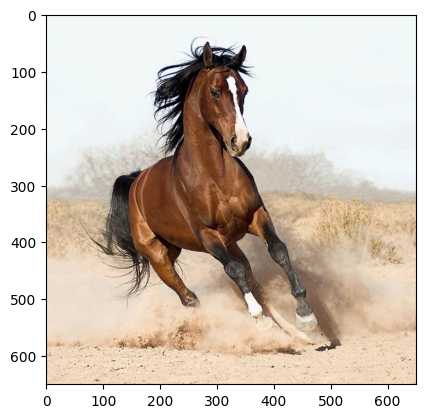

In [ ]:
import os
if not os.path.exists('testimg.jpg'):
  #!wget "https://drive.google.com/uc?export=download&id=1nGpIBGphU3uxngGM5kclLj58tFo_ZNf1" -O testimg.jpg
  !wget https://keio.box.com/shared/static/aesvle22z4l8bloc7b494ousjhfbdlt4 -O testimg.jpg

transform = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.ToTensor(),
])

test_image = Image.open("./testimg.jpg")
test_image_tensor = (transform((test_image))).unsqueeze(dim=0)

image_size = test_image.size
print("image size: ", image_size)

plt.imshow(test_image)

torch.Size([1, 512, 7, 7])
torch.Size([1, 25088])
pred:  ox


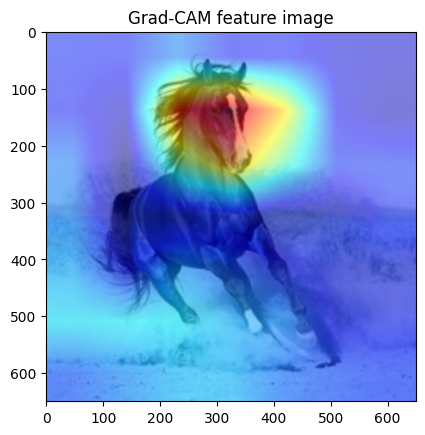

In [ ]:
grad_cam = GradCam(model)

feature_image = grad_cam(test_image_tensor).squeeze(dim=0)
feature_image = transforms.ToPILImage()(feature_image)

pred_idx = model(test_image_tensor).max(1)[1]
print("pred: ", labels[int(pred_idx)])
plt.title("Grad-CAM feature image")
plt.imshow(feature_image.resize(image_size))

# 課題

入力画像を変えて、注目点の変化を確認しなさい


# なぜ深層学習はうまくいくのか？

## なぜ収束するのか？

横幅の広いNNの訓練誤差には孤立した局所最適解がない
- 局所最適解は大域的最適解とつながっている
- 勾配法で大域的最適解に到達可能かは別問題

定理

$n$個の訓練データ$(x_i, y_i)^n_i=1$が与えられ、損失関数Lを凸関数とする
任意の連続な活性化関数について、横幅がデータサイズより広い2層NN$f_(a,W)(X) = \sum^M_{m=1}a_m\eta(w^T_m x)$に対する訓練誤差$\hat{L}(a, W)=\frac{1}{n}\sum^n_{i=1}L(y_i, f_{(a,W)}(x))$の任意のレベルセットの弧状連結成分は大域的最適解を含む

つまり、任意の局所最適解は大域的最適解となる

<img src='http://class.west.sd.keio.ac.jp/dataai/text/losslandscape.jpg' width=600>

深層学習はなぜうまくいくのか？という問いは現時点でも大きな課題  
数学による深層学習の原理究明が試みられている

- Li and Yuan (2017):ReLU，入力はガウス分布を仮定  
SGDは多項式時間で大域的最適解に収束
学習のダイナミクスは2段階→最適解の近傍へ近づく段階+近傍での凸最適化的段階  
- Soltanolkotabi(2017): ReLU，入力はガウス分布を仮定  
過完備(横幅>サンプルサイズ)ならば勾配法で最適解に線形収束する
- Brutzkuset al. (2018): ReLU  
線形分離可能なデータなら過完備ネットワークで動かしたSGDは大域的最適解に有限回で収束し過学習しない
- Zeyuan Allen-Zhu Microsoft Research(2018): 過剰パラメータを持つNNであればSGDを使った学習は最適解に多項式時間で到達できることを示したと主張  
過剰パラメータとは学習サンプル数よりパラメータ数の方が多いことであり、実際多くのNNの学習では過剰パラメータを利用している  
この証明では多層で有効かつ現実的なネットワークであるReLUを利用しており期待大

# ディープラーニングはなぜ汎化するのか

機械学習の目標は、学習データに対してうまく振る舞うことではなく、未知データに対してもうまく振る舞えるような汎化能力を獲得すること

- 一般的にパラメータ数が多く、強力、つまり多くの関数を表現できるようなモデルはそうでないモデルに対して汎化しにくいことが知られている
- これに対しニューラルネットワークは強力でありながら汎化する
  - 深い謎…
  - 実際、学習データのラベルをランダムなラベルに置き換えたデータに対してもディープラーニングモデルは学習できるなど、高い表現力を持つことがわかる
  - 学習アルゴリズムは学習データから情報を多く取りすぎない方が汎化しやすいことは証明されている

数学理論に基づいて深層学習を「謎な技術」から「制御可能な技術」へ変えようと努力が続けられており、深層学習を超える新しい方法論の構築にもつながると期待されている
- 例えば、物理法則を発見する機械学習モデル`AI Feynman`がある
  - 問題を単純で、変数の少ないものに変換する事を繰り返して解く
  - ニューラルネットワークによって関数同定問題を改善している
  - 既存のソフトウェアを上回る予測精度を達成するとされている

 # PyTorch Debugging Tips


このあたりまで学習を進めると、自身でデータを投入したり、モデルを修正、設計したりすることも容易であろう

そこで、デバッグに関する情報をまとめておく

## デバッグ初級編

- 文法上の問題は当然だが調べて取り除く

- 型の問題でエラーになる場合は、型や内容を調べて、とにかく合わせこめること

- エラーメッセージをとにかく確認する
  - 初心者はエラーメッセージの英語を読まずに、エラーが出たという事実だけで参ってしまうことが多い
  - エラーメッセージの確認は基本であり、これを追いかけること、少なくとも、エラーメッセージで検索するぐらいはやること

- 動作はするが、結果がおかしい場合は、動作を追いかけること
  - デバッグの仕方についてもある程度経験的に学べているとは思う尾が、その基本は「画面に表示してとにかく問題となる箇所を追いかける」ことである

- インストールバージョンの確認や更新を行うこと

- 自己構築の環境で問題が発生している場合は、Colabなどで動作確認するとよい
  - しばしば、GPUの違いやその対応状況によるトラブル、GPUメモリ搭載量によるトラブルなどが発生する

## デバッグ中級編

ある程度知識がひつよとなるのは、「動作するがうまくいかない」という場合である

次のようなパターンが存在する

- 仕様通りの設計はできているが、その設計自体の性能が不足し、ロスが下がらない、変な結果になるなど
  - モデルを修正することになるが、決して動作として間違えているわけではない
  - この点に気づかなければ、見当違いな修正を繰り返す可能性がある

- 型の合わせ込みで失敗しており、型はあっているが中身があっていないため正しく収束しない、なぜかしら出力がNaNになるなど

  - 各処理ステップの動作や出力結果を追いかけることになるが、大量のテンソルの中身を見ても何が正しいのかは判断が厳しいところ
  - バッチサイズを1にする、わかりやすい入力データを一時的に作るなどして、判断する
  
- 途中で固まる、ロスがとんでもない値で収束しない、メモリ不足になるなど
  - 設計そのものが間違えている可能性もあるが、Colabの場合仮想環境を完全にリセットして動作しなおすとうまくいく場合もあるので注意

## 身に着けたい対処方法(1. ネットワーク途中の結果を見たい)

ネットワークのforwardパスのある部分の結果を見たいことはしばしばあるであろう

- まずは、そのネットワーク定義の中にprintを埋め込めばよい

- 埋め込むのが嫌だ、もしくは、その部分の入力に狙った値を入れたい場合
  - ならば、次のコードが利用できる
  - これでNoNやInfといったイレギュラーな値が、望ましくない形で出ているかがわかる

参考コード

```
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.cl1 = nn.Linear(25, 60)
        self.cl2 = nn.Linear(60, 16)
        self.fc1 = nn.Linear(16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        x = F.relu(self.cl1(x))
        x = F.relu(self.cl2(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)
        return x
def hook(model, input, output):
    if hasattr(model,'activations'):
        model.activations = torch.cat([model.activations,output.detach().unsqueeze(0)],dim=0)
    else:
        model.activations = output.detach().unsqueeze(0)
```

このコードを用いて、例えば、
```
model = MyModel()
model.fc2.register_forward_hook(hook)
x = torch.randn(1, 25)
output = model(x)
print(model.fc2.activations)
```
とすると結果を入手できる


- ネットワークのbackwordパスはPyTorchの自動微分で行われるので手が付けられない…
  - そんなことはありません
  - `torch.autograd.set_detect_anomaly(True)`と記述すれば、backwordパスで計算に失敗した層に関する詳細情報を得ることができる

身に着けたい対処方法(2. NaNを避けたい)

ネットワークがNaNを出力し、学習が進まないという事象が発生する場合がある
- 初期値や途中の計算値の組み合わせにより、巨大な値が算出され、問題はないが、NaNとなる可能性がある
- -infやinfといった値が生成され、NaNとなる場合などが含まれる

この場合は、`torch.clamp`を用いて、問題となっている出力変数の値の範囲を固定してしまうことである
- ある程度大きい値で制限して置けば、学習上問題とならない

```
torch.clamp(出力変数名, min=-65504.0, max=65504.0)
```

などとすればよい

# PyTorchの実行速度を向上させるTips

かなり学習も進んできた
- ここから先は、さらに実行時間が長く、学習が複雑かつ厄介な問題が続く
- そこで、備えとして実行速度を向上させるテクニックについて説明する
- 特にここにある事項について、必ず効果が得られるというわけではないため全てケアしているわけではないが、個人で実行する際には注意するとよい


## DataLoaderでWorkerを使用する

簡単に修正出来て、比較的効果の高い方法である

```
DataLoader(dataset, num_workers=8)
```
データローダにこのようにnum_workersを指定することで、競合問題が発生しているときも、これを回避し、遅延を隠ぺいできる可能性がある

これには、もう少し説明が必要であろう
- グローバルインタプリタロック(GIL)ロック問題というのがある
- Pythonなどプログラミング言語のインタプリタの実行単位であるスレッドによって保持される、スレッドセーフでないコード、つまり並列して実行すると支障が発生するコードを、他のスレッドと同時に共有して実行しないように排他的なロック機構を設ける仕組み
  - 電車のセマフォなどを用いて分散システムでよく説明されている

この例では、8つのバッチをそれぞれスレッドではなく、別のプロセスで処理するようになるため、GILロックを回避する

このワーカーの数については議論が必要であるが、おおよそ経験的に、
$$num_{worker} = 4 \times num_{GPU}$$
とするとよいであろう

なお、メモリ使用量が増えるため、大きなモデルを扱う時には注意すること

## メモリをピン止めしたままにする

メモリピンダウンは重要なテクニックであり、メモリピンダウンという用語と共にその意味を抑える必要がある

DNNの学習を進めていると、GPUメモリ不足によるエラーに遭遇した経験があるであろう
- ところが、実行しなおすと、とたんにエラーがなくなる
- どう考えても、今試しているモデルがメモリを大量に利用するとは思えない

といった疑問を抱いているのではないだろうか

このような問題を引き起こしているのが、メモリピンダウン(メモリのピン止め)であり、メモリをあらかじめ作業の割り当て場所として確保、予約していることにより発生している

なお、普通のPCのメモリにもピンダウンは存在し、ピン止めすると、そのメモリはディスクにスワップされなくなる
- 後で使うデータがわかっている場合は、その格納領域をピンダウンすればよい
- さらに速いキャッシュの中でピンダウンすることもある
- ピンダウンは高速化手法として有効だが、メモリ利用効率が下がるというデメリットがある

これを解消しようとして、ピンを外す、つまりメモリを開放することができる
- ただし、開放するということは、実行速度を低下させることになる
- なにかしらネットからコードをとってきて試してみるという場合、中にメモリを解放するコードが入っている場合は、実行速度に注意する必要がある
- `torch.cuda.empty_cache()`というコードには注意すること

DataLoaderは、メモリピンダウンを使うことで、取得したデータのTensorを自動的にピン止めされたメモリに置き、CUDA対応GPUへのデータ転送を高速化している
-  明示的に指定するには、`Dataloader(dataset, pin_memory=True)`とする

torch.cuda.empty_cache()をむやみに呼び出してはいけない

## CPUとGPU間の無駄なデータ転送を避ける

GPUはCPUに比較して何十倍も高速に計算できる能力を持っている
- 一方で、CPUとGPUの間でデータをやり取りする必要があるため、このデータ転送に係る時間がオーバヘッドとなる
- つまり、そのオーバヘッドに見合うだけの速度向上が見込めればGPUを使う意味があるということ
- 一般的には、データ転送よりも計算のコストが大きいため、GPUを使うと得をするが、データ転送をなめてはいけない

メモリコピーは大きなオーバヘッドを伴うことを知っておくこと
- Pythonの変数間代入におけるエイリアシングなど、既に学んだ通り、メモリコピーはとにかくコストのかかる処理である

Pytorchにおいては、`.cpu()`, `.item()`, `.numpy()`, `.nonzero()`, `.tolist()`といったコマンド(メソッド)を利用する際には、その必要性を十分に吟味すること
- これらの呼び出しは、毎回GPUからCPUにデータを転送し、特に小さなデータを細かく転送するとパフォーマンスを大きく低下させる

代わりに `.detach()`, `.from_numpy()`, `.as_tensor()`を使うこと
- `detach`はGPUに転送せず、その変数にアタッチされている計算グラフ(Pytorhが逆伝搬のために記録している計算履歴情報)を削除する

さらに、データ転送が重なる場合は、`tensor.to(non_blocking=True)`を使用するとよい


## PyTorch JITによるポイントワイズ(エレメントワイズ)演算のカーネル融合

コードに対して注釈を与えるように最適化コードを埋め込む必要があるが、強力な方法である

PyTorch JITを用いて、隣接するポイントワイズ演算を自動的に1つのカーネルに融合することでメモリの読み書きを節約することができる
- 例えば、gelu関数は5つのカーネルを1つに融合することで、100万個のベクトルに対して4倍高速化できるとされている

以下の例を挙げておくので、各自で調べるとよい
```
@torch.jit.script # JIT decorator
def fused_gelu(x):
    return x * 0.5 * (1.0 + torch.erf(x / 1.41421))
```

## バッチサイズは2の累乗か8の倍数

Nvidia GPUのテンソルコアは、行列の次元が2の累乗のとき行列乗算性能を発揮する構造となっている

## データ転送とカーネル実行をオーバーラップさせる

適用可能な場合は`tensor.to(non_blocking=True)`を使用する
- データ転送と実行をオーバーラップさせ、実行時間を短縮できる
  - non_blocking=Trueにより非同期のデータ転送を可能にして実行時間を短縮させることができる
- なお、データローダなどはCUDAのコアレスアクセスを率先して使うように最適化されているため、これによる効果は限定的かもしれない


## GPUに直接テンソルを構築

`t = tensor.rand(2,2).cuda()`

この記述では、まずCPUでテンソルを作成した後GPUに転送する、という処理が行なわれる
- つまり、オーバヘッドが大きい

代りに次のようにする

`t = tensor.rand(2,2, device=torch.device('cuda:0'))`

直接GPU上にテンソルを生成することができる
- その他、`torch.empty()`, `torch.zeros()`, `torch.full()`, `torch.ones()`, `torch.eye(`), `torch.randint()`, `torch.rand()`, torch.randn()`などでも利用できる

その他の場合でも、例えば、ループの中で何度もテンソルを初期化するなどする場合、毎回CPUからGPUに転送するのは無駄である
- ループに入る前に最初にCPUで作成して、GPUに転送した後、これをGPU内で保持しておき、ループの中では、GPU内で保持した値をGPU内でcopyして利用するといった工夫も有効であろう

## 16ビット精度の利用

このテキストでも、画像生成ネットワーク、例えばtext-to-imageなどでは率先して使っているが、単精度演算にするとGPUの計算性能を飛躍的に拡大できる

メリットは次の通り

- メモリ使用量が半分になるためメモリを有効に利用できる
  - つまりバッチサイズを2倍にして、トレーニング時間を半分にすることができる
  - 一部の古いGPU、例えばV100や2080Tiなどは16ビット計算に最適化されているため、3倍から8倍といったスループット向上が期待できる

これには、Tensorの宣言を16ビットにするなど、様々工夫が必要である

一方で、これを簡単化する方法もいくつか存在する
- Pytorch Lightingでは、`Trainer(precision=16)`とする
- `from fp16util import network_to_half`を利用して、例えば`net = network_to_half(net)`とする

なお、GPUのアーキテクチャによって、得意な精度が異なっている
- 他も利用できるが、エミュレーションが入るため実行速度は落ちる
  - Turingだと、INT1,4,8/FP16
  - Ampereだと、INT1,4,8/FP16,64/TF32/bfloat16
  - Hopperだと、INT8/FP8,16,64/bfloat16/TF32

但し、精度を16にしたからと言って、必ず良くなるとは限らない
- アルゴリズム、データ、問題に依存し精度に影響する可能性がある
- モデルの精度性能と速度性能のスイートスポットを見つける必要がある

Pytorchの自動混合精度(AMP)パッケージを使えば、PyTorchでの混合精度の利用が簡単になる

## オプティマイザが重みを更新する前に勾配をNoneに設定

`model.zero_grad()`または`optimizer.zero_grad()`として勾配をゼロに設定する
- どちらも同じ意味なので、どちらか実行すればよい
- これですべてのパラメータに対して memsetが実行され、読み取りと書き込み操作によって勾配が更新される
- gradientsをNoneに設定すると、memsetは実行されず、書き込み操作のみでgradientsが更新されるため、gradientsをNoneに設定する方が高速

```
model.zero_grad(set_to_none=True)
# or
optimizer.zero_grad(set_to_none=True)
```

## 勾配の蓄積

この方法はGPUサイズが小さいときに実践的な方法である

- 大きなバッチサイズを模倣するため1つおきのバッチで重みを更新する
- より多くのデータサンプルからの勾配を求めるため汎化性能の向上が見込める

```
for i, (features, target) in enumerate(dataloader):
    # Forward pass
    output = model(features)
    loss = criterion(output, target)
    # Backward pass
    loss.backward()
    # Only update weights every other 2 iterations
    # Effective batch size is doubled
    if (i+1) % 2 == 0 or (i+1) == len(dataloader):
        # Update weights
        optimizer.step()
        # Reset the gradients to None
        optimizer.zero_grad(set_to_none=True)
```

## 推論・検証では勾配計算をオフにする

推論と検証のステップでモデル出力を計算する場合は勾配計算が不要である
- PyTorchはrequests_grad=Trueとすると、よりサイズの小さい中間メモリバッファを使用して高速に演算しようとする
- 勾配に関わる演算が必要ないことが分かっている場合は、勾配計算を無効にすることで、追加リソースの使用を避けることができる

```
# torch.no_grad() as a context manager:
    with torch.no_grad():
    output = model(input)
# torch.no_grad() as a function decorator:
@torch.no_grad()
def validation(model, input):
    output = model(input)
return output
```

## torch.backends.cudnn.benchmark=Trueの設定

学習ループの前に `torch.backends.cudnn.benchmark = True` を設定すると計算を高速化できる

異なるカーネルサイズの畳み込み演算では、cuDNNアルゴリズムの性能が変化しやすく、これを自動的にチューニングする
- 入力サイズが頻繁に変化しない場合はこの設定をオンにするとよい
- 入力サイズが頻繁に変化する場合は、自動チューナーが頻繁にベンチマークを実行するため、パフォーマンスが低下する

この手法により、1.5倍程度高速化できる

## 4D NCHWテンソルにはchannels_lastメモリ形式を使用

4D NCHWをNHWC形式として再編成し、channels_lastメモリフォーマットを使用すると、メモリ内で最も密度の高いフォーマットとなり、2割程度高速時実行できる
- 画像限定の方法
- 4次元NCHWテンソルは、メモリ上で各チャンネル（赤/緑/青）ごとにクラスタリングされる
- 従って、`x = x.to(memory_format=torch.channels_last)`と変換すると、NHWC（channels_lastフォーマット）として再編成され、RGBレイヤーの各ピクセルが距離的に近くなる


## バッチ正規化直前の畳み込み層のバイアスはオフにする

バイアスの効果はバッチ正規化の平均減算で打ち消されるため、意味がない
- ならば、オフにしてしまっても構わない
- モデルパラメータ、実行時間、メモリを節約できる

```
nn.Conv2d(..., bias=False)
```
とする

## DistributedDataParallelを使用する

PyTorchには複数のGPUで学習するためのモデルが2つある
- DataParallel(DP)は、複数のGPUに渡ってバッチを分割する
  - モデルを各GPUにコピーする必要があり、GPU0で勾配を計算した後、他のGPUと同期する必要がある事を意味する
  - GPU内部でのデータ転送を伴うため、CPU-GPU間ほどひどくはないが、回数が重なるとオーバヘッドが大きくなる
- DistributedDataParallel (DDP)は、各GPU上にモデルを縦割り分割したコピーを作成し、各GPUでデータの一部のみ利用するように分割される
- この場合、各バッチにおいて、GPU間のデータ転送が一度しか発生しないことを意味する

DistibutedDataParallelを利用し、バッチサイズを大きく設定するとよい

## コードのプロファイリング

どの関数、どの場所でどの程度時間がかかり、どの程度呼び出されているか、これらの情報を入手することなく、実行速度を削減することはほぼ無理

このような情報を入手する方法について簡単に紹介しておく

- torch.profilerを使う
```
with torch.profiler.profile(
    schedule=torch.profiler.schedule(
        wait=2,
        warmup=2,
        active=6,
        repeat=1),
    on_trace_ready=tensorboard_trace_handler,
    with_trace=True
) as profiler:
```
などと宣言しておき、
```
optimizer.step()
profiler.step()
```
といった具合に、optimierでパラメタ更新した後に、プロファイラ情報も保存するようにする  
これで、json形式でプロファイラ情報が書き込まれる
  - これを見たい場合は、tensorboardを使うのが便利
  - `pip install torch_tb_profiler`として、`tensorboard --logdir logdir`としてみると様々な情報を取得できる

- Torch Lightingでお気楽に取得する  
`Trainer(profile=True)`  
とするか、アドバンストプロファイラを用いて
```
profiler = AdvancedProfiler()
trainer = Trainer(profiler=profiler) です．
これは、非常に詳細な情報を得ることができます。
```
とすることで、テキスト情報として結果を取得できる
  - シンプルでさっと済ますにはよい


# なぜ機械学習プログラミングは忌み嫌われるのか？

ソフトウェア開発では仕様の明確さ、システムの効率・堅牢性、保守のしやすさが求められる
- しかしながら、これまでの内容は少々これらとは異なると感じるのではないだろうか
- なぜ記述が少々変わってもうまく学習できるのか？
  - これではどのようなネットワークが最もよいのかよくわからない
- どのようなデータでもうまく学習できるという保証はない

機械学習プログラミングでは次の点が総じて忌み嫌われている

- 仕様がわかりにくい
  - 一般にソフトウェアはプログラムが正しく動作しているということを正しく理解できる、という想定で設計されている
    - 間違ったコードではエラーが発生され、また、間違った結果を出力するため、時間をかければバグを発見できるという前提がある
  - 機械学習のモデルに正しく動作していると理解すること自体が困難であえり、誤りのないコードがいつも正しい解を出すとは限らない
    - あるべき値を用いて学習するため、ミスするとあるべき値を使ってあるべき値を求めてしまうことすらある
    - 誤りのあるコードの方がもっともらしい答えを出すことすらある

- 仕様そのものが流動的
  - 機械学習はアルゴリズムに確固たる正しい手法が定義されておらず、正しく実装しても、正解に至る良いアルゴリズムかどうかはわからない
    - 実行して精度が高ければよいアルゴリズムといった定義でしかない
    - 層数や層にどのモデルを使うかなどに決まった規則や答えがない
    - 試行錯誤がモノをいう
  - 研究者でも、なぜこれで精度が上がるのかよくわからない方法、どちらが本当によいのか良く分からない方法、謎なテクニックといった、迷信のような手法がいくつか存在する
    - そしてこれらは、時代と共に変化する
    - 当初はドロップアウトが画期的な技術とされてきたが、すぐにそのデメリットも明らかとなり、現在ではあまり利用されない
    - バッチノーマライゼーションを行う際、活性化関数の直前に行うのか、活性化関数の後に行うのかは意見が分かれている
    - CNNにおいて、画像縮小にMax poolingが用いられるが、ストライドを用いてもよく、精度に大きな差はないことから、ストライドを率先して使うべきという意見があるなど
  - このようなことから、どうしても試行錯誤が必要となるが、この試行錯誤によるコードの修正が蓄積する結果、保守性の悪さに繋がる

- フレームワークが不安定で分断されている
  - 機械学習フレームワークの多くは堅牢なソフトウェアとはとてもいえない
  - 様々なソフトウェアやライブラリのバージョンが正しく合致しないと動作しない
  - 最新の機能を利用したくでも、バージョンの制約から利用できない、誤ってバージョンを上げたために動かなくなるということがしばしば発生する
    - 使いやすい、よくできたフレームワークはそういうことがないようにしっかりと後方互換性が保たれている
    - そうでなければ、怖くてシステム更新などできない
  - 大きく分けて、PyTorch派とTensorflow派、R派があり、さらにKeras派など様々な派閥がある

これらを解決するフレームワークの登場が期待されている
- この点で先進性や研究利用などを考え併せれば、現時点でPyTorchという選択肢になる

# 課題1(ランタイムパラメタ変更)

学習途中でパラメタを強制変更することで、どのような変化が起きるかを確認する

そこで、
- 普通に学習させる
- パラメタを強制的に変更して学習させる

これら2つの場合を比較し、
- パラメタを強制的に変更しても学習することができるか？
- 普通に学習させた場合と、学習の速度や精度についてどのような変化があるか？

を確認する

課題は、上記2点についての考察も含めること

用いるプログラムは、このテキストの「参考プログラム」の一番最初に記述した無加工のプログラムで、モデル定義クラスの部分は次のように修正しなさい

```
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.cn1 = nn.Conv2d(1, 20, 5)
        self.pool1 = nn.MaxPool2d(2)
        self.cn2 = nn.Conv2d(20, 50, 5)
        self.fc1 = nn.Linear(50 * 8 * 8, 8)
        self.fc2 = nn.Linear(8, 8)
        self.fc3 = nn.Linear(8, 10)
    def forward(self, x):
        x = F.relu(self.cn1(x))
        x = self.pool1(x)
        x = F.relu(self.cn2(x))
        x = x.view(len(x), -1) # Flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)
```

このモデルの学習において、fc2を強制的にweightを全て0.5にしなさい

すなわち、
```
        xの生成
        model.fc2.weight.data = 0.5だけで構成されたtorch.tensorの配列
        output = model(x)
        loss = criterion(output,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
```
等とする

# 課題2(複数目的による学習)

## 課題2-1
次のコードは、Processing( https://processing.org )を用いて丸:0、四角:1、三角:2の3種類の画像を32x32の中にランダムな場所に書き出し、その画像の種類の番号(0-2)、中心座標、大きさといった画像パラメタをcsvファイルとして保存するプログラムである

各自Processingをインストールしてこのプログラムを実行し、生成されたデータセット(imgフォルダにある2000枚の画像データおよび、各画像データのパラメタ集であるdata.csv)を読み込み、画像の種類および画像の中心をそれぞれ求める学習モデルを作成しなさい

また、次の事項を守ること

- モデルは分岐型としたうえで自由に設計してよい
- 25%を検証データとしなさい
- 検証の際、ラベルの正答率、座標の平均MSEをそれぞれ評価しなさい
- 精度は問わないが、極端に悪い場合は採点で考慮される

```
int xsize = 32;
int ysize = 32;
int wmax = 16;
int wmin = 8;
int numofshape = 2000;

String[] savestr = new String[numofshape];

void setup(){
  size(32, 32);
  ellipseMode(CENTER);
  rectMode(CENTER);
  noLoop();
}

void draw(){
  for(int i = 0; i < numofshape; i++){
    background(255);
    drawshape(i);
  }
  saveStrings("data/data.csv", savestr);
}

void drawshape(int num){
  int x = int(random(xsize-wmin*2))+wmin;
  int y = int(random(ysize-wmin*2))+wmin;
  int w = int(random(wmax-wmin))+wmin;
  int t = int(random(3));
  if(t == 0){
    circle(x, y, w);
  }else if(t == 1){
    rect(x, y, w, w);
  }else if(t == 2){
    triangle(x, y-w/2, x-w/2, y+w/2, x+w/2, y+w/2);
  }
  save("data/img/img"+num+".jpg");
  savestr[num] = str(t)+","+str(x)+","+str(y)+","+str(w);
}
```

## 課題2-2

課題2-1について、画像の幅も推定し、同様に精度を求めなさい

また、画像上に、
- 丸であれば青
- 四角であれば赤
- 三角であれば黄

の四角(bounding box)を描画して表示させなさい
- なお、数枚のサンプルがあればよい
